##1. Introduction 
* The [original dataset](https://www.kaggle.com/datasets/dilwong/flightprices)
* The flight dataset contains the information about the one-way flight and its price as found on expedia between 04/16/2022 and 10/05/2022
* More details about the dataset can be found [here](https://www.kaggle.com/datasets/dilwong/flightprices)
* For the purpose of the analysis, the original dataset has been sampled at 1%
* **Please download the [zip file](https://drive.google.com/file/d/1aJBf08SdS0KkO-QMo686hjL77J1jnrMK/view?usp=sharing) (sampled_itineraries.csv.zip) . Autograder didn't allow to upload the zip file saying it was too large. Upload the entire zip file to your Google Drive root folder.**
* The above step is required to run the project
* We will try to predict the flight price(using regression techniques) and also predict whether flight prices are above or below average using  classification techniques.

###1a. Import the Data


In [1]:
#Import file from google drive by connecting to it
import pandas as pd
from google.colab import files
import zipfile
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

#!unzip gdrive/My\ Drive/Flight_Prices.zip
#flight_df = pd.read_csv(r'/root/it_sample.csv')

Mounted at /content/gdrive


In [2]:
#install needed libraries of pyspark and pandasql
!pip install pyspark
!pip install pandasql
import pyspark.pandas as ps
from pandasql import sqldf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 39 kB/s 
     |████████████████████████████████| 199 kB 76.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=86f67b306e8f3760c6028dff5307be2019ac7905a0286d7d634731ed7088ad49
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=4162e844cf18596ad9404a88c9fbd15e0d1cdae5d67c96be252313d832189d36
  Stored in directory: /root/.cache/pip/wheels/ed/8f/46/a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
Successfully built pandasql


In [ ]:
# THe below code was used to initially generate the 1% sample from the original dataset to obtain approx 800k records

#Since the file contains ~8 million rows; we will only use around 800k by the following. 
#Alternatively to speed up modeling this 1% instance was saved to csv and used to predict the model  
#n = 100  # every 100th line = 1% of the lines
#flight_df = pd.read_csv(r'/content/itineraries.csv', skiprows=lambda i: i % n != 0)
# save the sampled csv file locally for later easy retrieval
#flight_df.to_csv('/content/sampled_itineraries.csv', encoding='utf-8', index=False)
#!zip -r '/content/sampled_itineraries.csv.zip' '/content/sampled_itineraries.csv' 

In [5]:
#unzip the file
!unzip gdrive/My\ Drive/sampled_itineraries.csv.zip

Archive:  gdrive/My Drive/sampled_itineraries.csv.zip
replace content/sampled_itineraries.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [7]:
# Load the dataset into dataframe
flight_df = pd.read_csv(r'/content/content/sampled_itineraries.csv')
print(len(flight_df))
flight_df.head()

821387


,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode,flightDayOfWeek,searchDayOfWeek
0,2bcf2f66e9c0d933d452ab9941adf829,2022-04-16,2022-04-17,ATL,DFW,LA0NX0MQ,PT2H16M,0,False,False,...,DAL,ATL,Delta,DL,Boeing 717,8160,725,coach,Sunday,Saturday
1,2de4d08a9dfbbc7ca74124ab5e6fbc9b,2022-04-16,2022-04-17,ATL,DTW,KA0NA0MC,PT4H50M,0,False,False,...,MCI||DTW,ATL||MCI,Delta||Delta,DL||DL,Airbus A320||Boeing 717,7800||6420,693||638,coach||coach,Sunday,Saturday
2,dba3f0829d2ce5c608558811ba871bd5,2022-04-16,2022-04-17,ATL,LAX,V0AIZNN1,PT7H2M,0,False,False,...,DFW||ONT,ATL||DFW,American Airlines||American Airlines,AA||AA,Airbus A321||Airbus A321,8580||11520,725||1215,coach||coach,Sunday,Saturday
3,e18561718207c3100af7ad656fb0ca4b,2022-04-16,2022-04-17,ATL,LGA,UAA0OKEN,PT5H35M,0,False,False,...,IAD||LGA,ATL||IAD,United||United,UA||UA,Embraer 175 (Enhanced Winglets)||,6660||5340,541||221,coach||coach,Sunday,Saturday
4,31ad4eaa9c6b23b471c6d8c960281180,2022-04-16,2022-04-17,ATL,PHL,JA2AA,PT2H7M,0,False,False,...,PHL,ATL,American Airlines,AA,Embraer 175,7620,667,first,Sunday,Saturday


##2. Data Cleaning 

In [8]:
# changing column data types
flight_df['flightDate'] = pd.to_datetime(flight_df['flightDate'])
flight_df['searchDate'] = pd.to_datetime(flight_df['searchDate'])

#create day of week column for search and flight date
flight_df['flightDayOfWeek'] = flight_df['flightDate'].dt.day_name()
flight_df['searchDayOfWeek'] = flight_df['searchDate'].dt.day_name()

flight_df['segmentsCabinCode'] = flight_df['segmentsCabinCode'].str[:5]

# keeping non null rows of major data to help in further data cleaning 
flight_df = flight_df[flight_df['flightDate'].notnull()]
flight_df = flight_df[flight_df['searchDate'].notnull()]
flight_df = flight_df[flight_df['startingAirport'].notnull()]
flight_df = flight_df[flight_df['destinationAirport'].notnull()]
flight_df = flight_df[flight_df['fareBasisCode'].notnull()]
flight_df = flight_df[flight_df['flightDate'].notnull()]
flight_df = flight_df[flight_df['travelDuration'].notnull()]
flight_df = flight_df[flight_df['elapsedDays'].notnull()]
flight_df = flight_df[flight_df['totalTravelDistance'].notnull()]
flight_df = flight_df[flight_df['baseFare'].notnull()]
flight_df = flight_df[flight_df['totalFare'].notnull()]
flight_df = flight_df[flight_df['isBasicEconomy'].notnull()]
flight_df = flight_df[flight_df['isNonStop'].notnull()]
flight_df = flight_df[flight_df['isRefundable'].notnull()]
flight_df = flight_df[flight_df['segmentsAirlineName'].notnull()]
flight_df = flight_df[flight_df['segmentsCabinCode'].notnull()]

print(flight_df.dtypes)

flight_df.head(5)

legId                                        object
searchDate                           datetime64[ns]
flightDate                           datetime64[ns]
startingAirport                              object
destinationAirport                           object
fareBasisCode                                object
travelDuration                               object
elapsedDays                                   int64
isBasicEconomy                                 bool
isRefundable                                   bool
isNonStop                                      bool
baseFare                                    float64
totalFare                                   float64
seatsRemaining                                int64
totalTravelDistance                         float64
segmentsDepartureTimeEpochSeconds            object
segmentsDepartureTimeRaw                     object
segmentsArrivalTimeEpochSeconds              object
segmentsArrivalTimeRaw                       object
segmentsArri

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode,flightDayOfWeek,searchDayOfWeek
0,2bcf2f66e9c0d933d452ab9941adf829,2022-04-16,2022-04-17,ATL,DFW,LA0NX0MQ,PT2H16M,0,False,False,...,DAL,ATL,Delta,DL,Boeing 717,8160,725,coach,Sunday,Saturday
1,2de4d08a9dfbbc7ca74124ab5e6fbc9b,2022-04-16,2022-04-17,ATL,DTW,KA0NA0MC,PT4H50M,0,False,False,...,MCI||DTW,ATL||MCI,Delta||Delta,DL||DL,Airbus A320||Boeing 717,7800||6420,693||638,coach,Sunday,Saturday
2,dba3f0829d2ce5c608558811ba871bd5,2022-04-16,2022-04-17,ATL,LAX,V0AIZNN1,PT7H2M,0,False,False,...,DFW||ONT,ATL||DFW,American Airlines||American Airlines,AA||AA,Airbus A321||Airbus A321,8580||11520,725||1215,coach,Sunday,Saturday
3,e18561718207c3100af7ad656fb0ca4b,2022-04-16,2022-04-17,ATL,LGA,UAA0OKEN,PT5H35M,0,False,False,...,IAD||LGA,ATL||IAD,United||United,UA||UA,Embraer 175 (Enhanced Winglets)||,6660||5340,541||221,coach,Sunday,Saturday
4,31ad4eaa9c6b23b471c6d8c960281180,2022-04-16,2022-04-17,ATL,PHL,JA2AA,PT2H7M,0,False,False,...,PHL,ATL,American Airlines,AA,Embraer 175,7620,667,first,Sunday,Saturday


###2a. Major Queries to help visualize the data 

In [9]:
#most searched route
most_searched_query = """Select startingAirport, destinationAirport, count(*) as total_searches  FROM flight_df Group by startingAirport, destinationAirport order by count(*) desc, startingAirport asc, destinationAirport asc"""
most_searched_df = sqldf(most_searched_query, locals())
most_searched_df.head(20)

,startingAirport,destinationAirport,total_searches
0,LAX,BOS,6481
1,LAX,JFK,6239
2,LAX,LGA,6166
3,BOS,LAX,6141
4,LGA,LAX,6124
5,JFK,LAX,5995
6,LAX,ATL,5785
7,JFK,ORD,5505
8,CLT,LAX,5491
9,ATL,LAX,5470


In [10]:
#most popular destination
most_popular_dest_query = """
select destinationAirport, count(*) as total  
from flight_df 
group by destinationAirport order by count(*) desc, destinationAirport asc
"""
most_popular_dest_df = sqldf(most_popular_dest_query, locals())
most_popular_dest_df.head(20)

,destinationAirport,total
0,LAX,71396
1,LGA,58370
2,BOS,55710
3,SFO,55255
4,DFW,52425
5,ORD,51799
6,CLT,51027
7,MIA,47087
8,ATL,46162
9,DEN,44026


In [11]:
#most folks travelling out of airport
most_popular_source_query = """
select startingAirport, count(*) as total  
from flight_df 
group by startingAirport 
order by count(*) desc, startingAirport asc"""
most_popular_source_df = sqldf(most_popular_source_query, locals())
most_popular_source_df.head(20)

,startingAirport,total
0,LAX,72631
1,LGA,56471
2,BOS,56368
3,SFO,55937
4,CLT,52464
5,DFW,50519
6,ORD,50131
7,ATL,46245
8,MIA,44655
9,DEN,44613


In [12]:
#avg fare per route
avg_total_fare_query = """
select startingAirport, destinationAirport, avg(totalFare) as avg_total_fare
from flight_df 
group by startingAirport, destinationAirport 
order by avg(totalFare) desc, startingAirport asc, destinationAirport asc
"""
avg_total_fare_df = sqldf(avg_total_fare_query, locals())
avg_total_fare_df.head(20)

,startingAirport,destinationAirport,avg_total_fare
0,MIA,OAK,698.627639
1,OAK,MIA,685.610462
2,OAK,CLT,662.242799
3,LGA,OAK,658.007484
4,OAK,LGA,656.879137
5,IAD,OAK,656.084556
6,PHL,OAK,646.984829
7,OAK,PHL,645.381450
8,OAK,BOS,642.425542
9,CLT,OAK,642.004000


In [13]:
#avg fare per route per stop and non-stop
avg_total_fare_per_stop_query = """
select startingAirport, destinationAirport, isNonStop, avg(totalFare) as avg_total_fare
from flight_df 
group by startingAirport, destinationAirport, isNonStop 
order by startingAirport asc, destinationAirport asc, avg(totalFare) desc
"""
avg_total_fare_per_stop_df = sqldf(avg_total_fare_per_stop_query, locals())
avg_total_fare_per_stop_df.head(20)

,startingAirport,destinationAirport,isNonStop,avg_total_fare
0,ATL,BOS,1,290.999902
1,ATL,BOS,0,280.043901
2,ATL,CLT,0,364.123908
3,ATL,CLT,1,241.063320
4,ATL,DEN,0,341.040169
5,ATL,DEN,1,285.548657
6,ATL,DFW,0,278.694963
7,ATL,DFW,1,223.396829
8,ATL,DTW,0,329.459359
9,ATL,DTW,1,281.915693


In [14]:
#avg fare per route per day of week
avg_total_fare_per_day_query = """
select startingAirport, destinationAirport, flightDayOfWeek, avg(totalFare) as avg_total_fare
from flight_df 
group by startingAirport, destinationAirport, flightDayOfWeek
order by startingAirport asc, destinationAirport asc, avg(totalFare) asc, flightDayOfWeek asc """
avg_total_fare_per_day_df = sqldf(avg_total_fare_per_day_query, locals())
avg_total_fare_per_day_df.head(20)

,startingAirport,destinationAirport,flightDayOfWeek,avg_total_fare
0,ATL,BOS,Tuesday,256.729330
1,ATL,BOS,Wednesday,266.323549
2,ATL,BOS,Saturday,270.271673
3,ATL,BOS,Monday,281.114012
4,ATL,BOS,Thursday,287.258646
5,ATL,BOS,Friday,294.458962
6,ATL,BOS,Sunday,339.431155
7,ATL,CLT,Tuesday,278.042972
8,ATL,CLT,Wednesday,289.959008
9,ATL,CLT,Saturday,298.206587


##3.EDA - > Data Visualization

1. Routes that in demand/ most searched routes

2. Which trend of source and trend of destination airport

3. What is the average fare based on route source air dest air average per 

4. Flying duration

5. Diff in nonstop vs multiple stop flights

6. For a given route on what day is cheapest flight

In [15]:
#import for visualization
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Most Searched Routes')

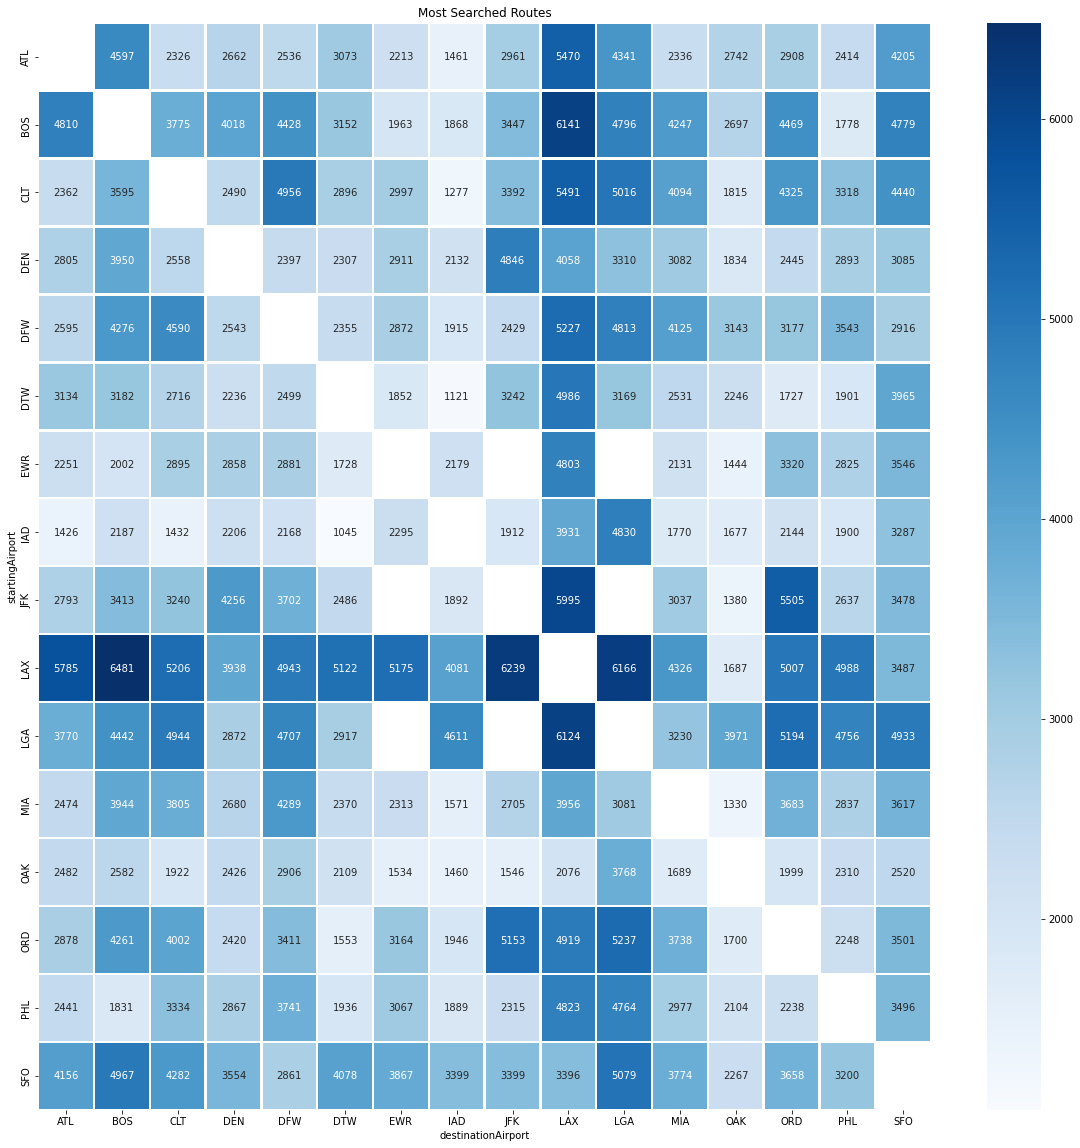

In [16]:
#Most searched Routes heatmap with most searched starting and destination comboniations in darkest color along with number of searches

most_searched_df_pivot = pd.pivot_table(most_searched_df, values='total_searches', index='startingAirport', columns='destinationAirport')
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(most_searched_df_pivot, annot=True, linewidths= 1.5, ax = ax, cmap= 'Blues', fmt = 'g')
ax.set_title('Most Searched Routes')


We see above that LAX-BOS is the most searched route among all the routes

In [17]:
#avg_total_fare_per_day made to pivot tabel to visualize properly and then plotted as line graph and heatmap
avg_fare_per_day_df_pivot = pd.pivot_table(avg_total_fare_per_day_df, values='avg_total_fare', index='startingAirport', columns=['flightDayOfWeek'])

[Text(0, 0.5, 'avg_total_fare'),
 Text(0.5, 0, 'startingAirport'),
 Text(0.5, 1.0, 'Average Fare for Airport By Day')]

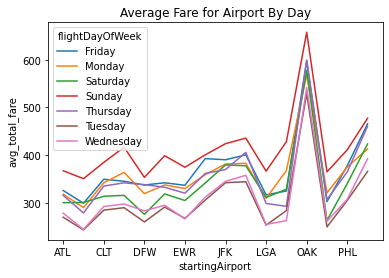

In [18]:
ay = avg_fare_per_day_df_pivot.plot()
ay.set(xlabel='startingAirport', ylabel='avg_total_fare', title ='Average Fare for Airport By Day')

We see above that the flight prices on average are always higher on Sunday and lowest either on Tuesday or Wednesday

Text(0.5, 1.0, 'Average Fare for Airport By Day')

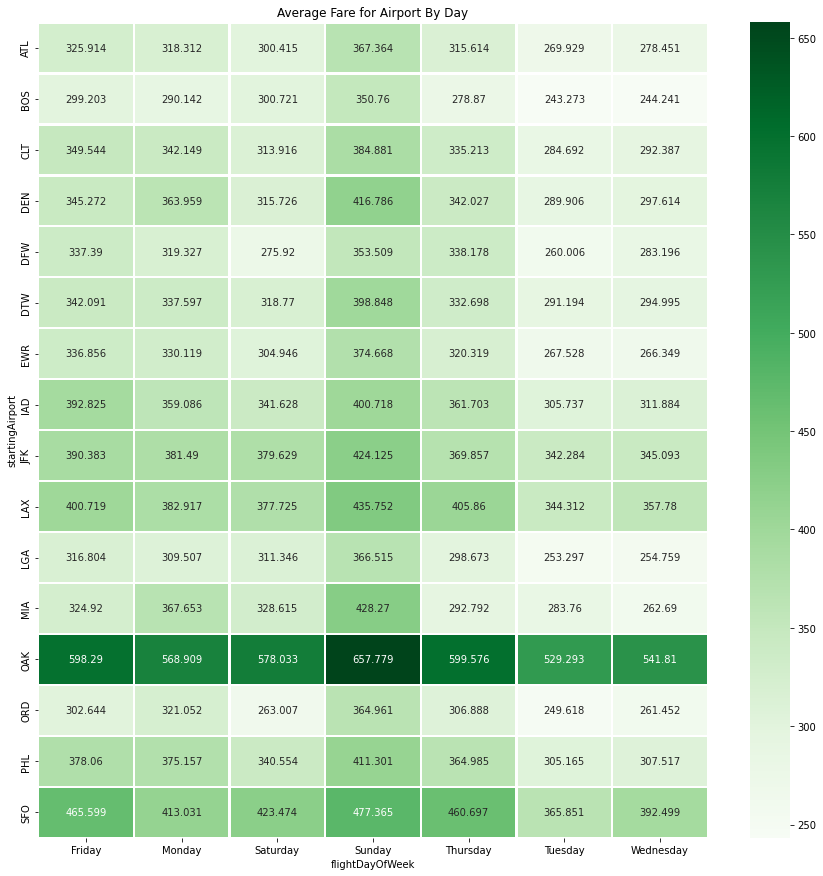

In [19]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(avg_fare_per_day_df_pivot, annot=True, linewidths= 1.5, ax = ax, cmap = 'Greens', fmt='g')
ax.set_title('Average Fare for Airport By Day')

We see above that of all the airports to travel out of, OAK airport has on average higher fares for almost all the days of the week compared to other airports.
This mostly means that flying out of OAK may be expensive than SFO

Text(0.5, 1.0, 'Average Total Fare')

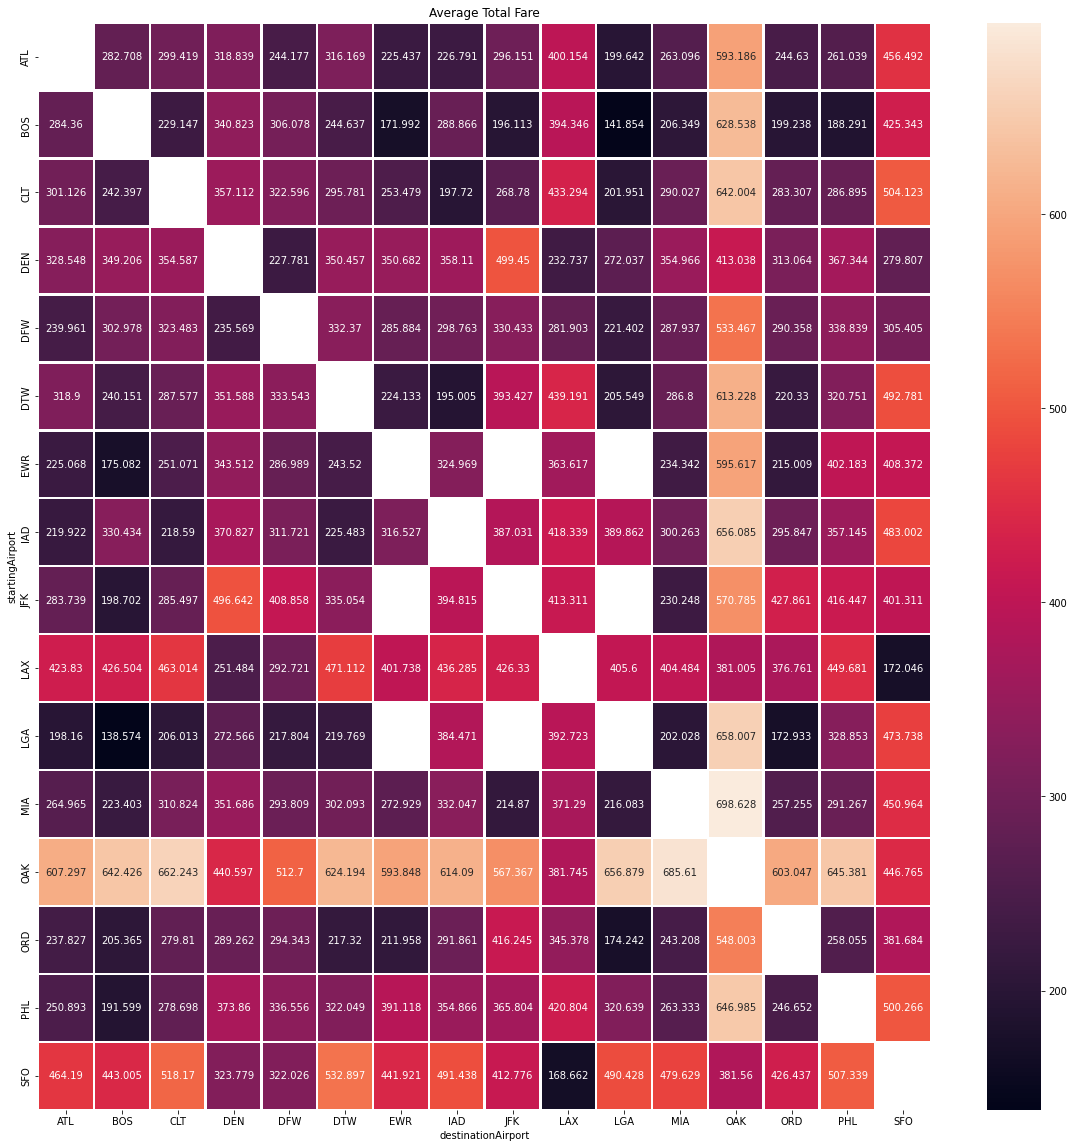

In [20]:
#Average total fare as a heatmap with average fare shown fpor starting to destination 
avg_total_fare_pivot = pd.pivot_table(avg_total_fare_df, values='avg_total_fare', index='startingAirport', columns='destinationAirport')
fig, ax = plt.subplots(figsize=(20,20)) 
avg_total_fare_pivot.head()
sns.heatmap(avg_total_fare_pivot, annot=True, linewidths= 1.5, ax = ax, fmt='g')
ax.set_title('Average Total Fare')


We see from above that MIA - OAK has the highest total fare on avg compared to other routes and LGA - BOS has the lowest fare on avg among all routes

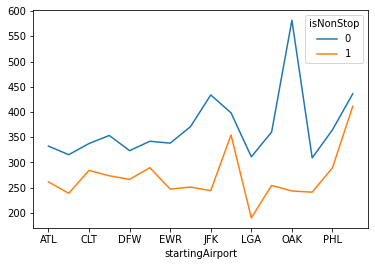

In [21]:
#avg_total_fare_per_stop converted via pivot table and then plotted as a line graph

avg_fare_per_stop_df_pivot = pd.pivot_table(avg_total_fare_per_stop_df, values='avg_total_fare', index='startingAirport', columns='isNonStop')
avg_fare_per_stop_df_pivot.plot()

We see from above that on average within US, non stop flights are cheaper than flights with stops. This appears counter intuitve per se, but that is the truth on average

[Text(0, 0.5, 'total'),
 Text(0.5, 0, 'destinationAirport'),
 Text(0.5, 1.0, 'Most Popular Destination')]

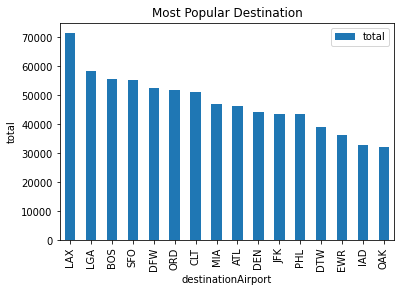

In [22]:
#Most popular destination based on total searches
ay = most_popular_dest_df.plot.bar(x = 'destinationAirport', y = 'total')
ay.set(xlabel='destinationAirport', ylabel='total', title ='Most Popular Destination')

We see that LAX is the most popular destination people want to travel to. Second in line is LGA.

[Text(0, 0.5, 'total'),
 Text(0.5, 0, 'startingAirport'),
 Text(0.5, 1.0, 'Most Popular Source Destination')]

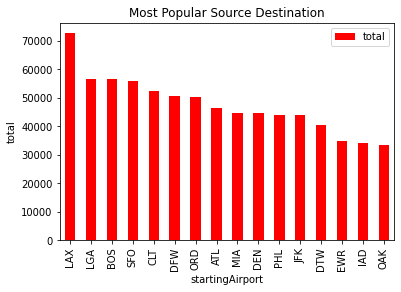

In [23]:
#Most popular starting airport
ax = most_popular_source_df.plot.bar(x= 'startingAirport',y = 'total', color =['red'] )
ax.set(xlabel='startingAirport', ylabel='total', title ='Most Popular Source Destination')

We see that most people are looking to fly out of LAX. Second in line is again LGA

Text(0.5, 1.0, 'Flight_Prices Correlation for all numerical features')

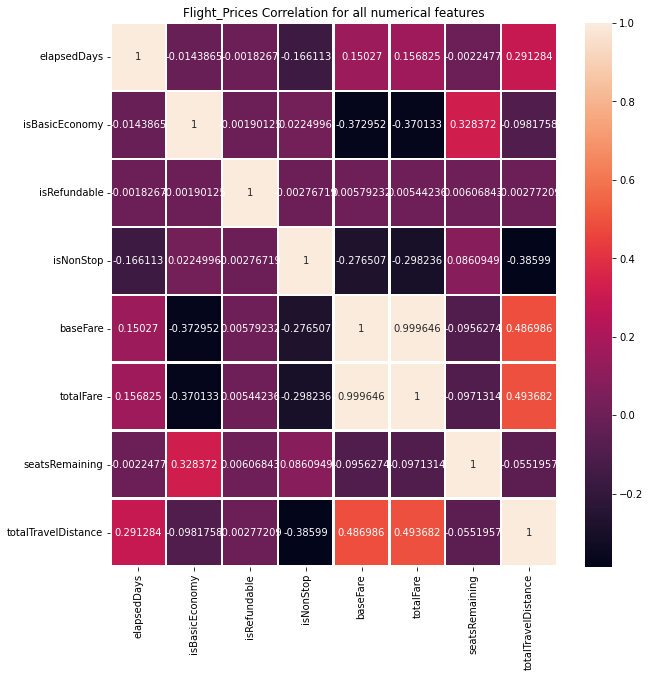

In [24]:
#Correlation map of all numerical features in flights_df - shows baseFare and totalFare both highly correlated so can use just one
flight_df.corr()
fig, ax = plt.subplots(figsize=(10,10)) 

sns.heatmap(flight_df.corr(), annot=True, linewidths= 1.5, ax = ax, fmt='g')
ax.set_title('Flight_Prices Correlation for all numerical features')


We see from above that baseFare and totalFare are highly correlated (close to 1). So, we only need to keep one of them as the label.
In addition to it, we see that baseFare is positively correlated to totalTravelDistance and negatively correlated to isBasicEconomy

In [25]:
# Write function to do the label encoding and return the label encoded data frame
from sklearn.preprocessing import LabelEncoder
#Label Encoding

def perform_label_encoding(input_df):
  input_df_copy = input_df.copy() 
  categorical_data = input_df_copy.select_dtypes(exclude=['int64', 'float','int32'])
  numerical_data = input_df_copy.select_dtypes(include=['int64', 'float','int32'])

  le = LabelEncoder()
  categorical_data = categorical_data.apply(LabelEncoder().fit_transform)
  input_df_copy = pd.concat([categorical_data, numerical_data], axis=1)
  input_df_copy.reset_index(drop=True)
  return input_df_copy

Text(0.5, 1.0, 'All_Flight_Prices Correlation')

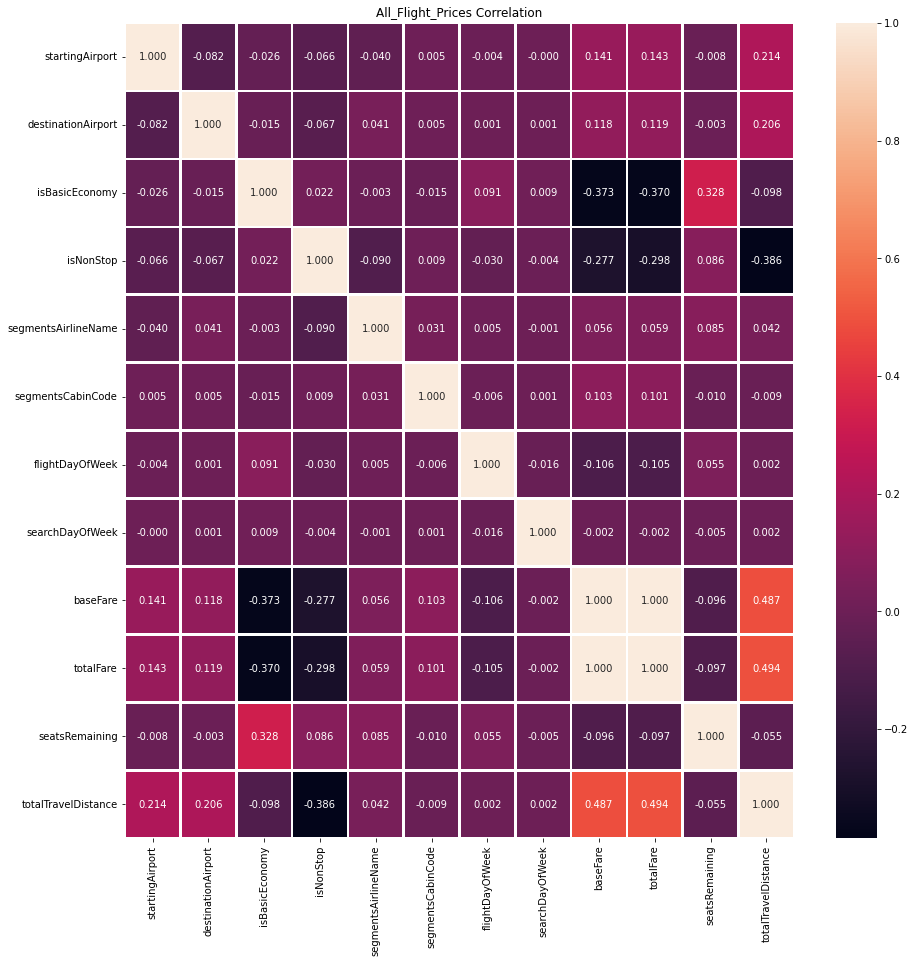

In [27]:
# Do label encoding and generate correlation matrix.

flight_ml_df = flight_df.copy() 
mlFeatureColumns = ['startingAirport', 'destinationAirport', 'isBasicEconomy', 'isNonStop', 'baseFare', 'totalFare', 'seatsRemaining',
                    'totalTravelDistance', 'segmentsAirlineName', 'segmentsCabinCode', 'flightDayOfWeek', 'searchDayOfWeek']
flight_ml_df = flight_ml_df[mlFeatureColumns]
flight_ml_df.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15,15)) 

flight_ml_df_encoded = perform_label_encoding(flight_ml_df)

sns.heatmap(flight_ml_df_encoded.corr(), annot=True, linewidths= 1.5, ax = ax, fmt='.3f')
ax.set_title('All_Flight_Prices Correlation')

We label encoded all the relevant features and generated the correlation matrix.
We see that baseFare and totalFare have correlation of 1. We can safely keep one of them. We will choose to keep baseFare moving forward.
Again totalTravelDistance is positively correlated to baseFare.
isBasicEconomy, isNonStop is negatively correlated to baseFare.


In [28]:
# Understanding Correlation matrix above
# We see that baseFare and totalFare are correlated. So we can select one of them - e.g. baseFare and ignore the totalFare
flight_ml_df_encoded.drop("totalFare", axis=1, inplace=True)

In [29]:
# Create X and Y dataset
X = flight_ml_df_encoded.copy()
y = X['baseFare']

# Remove baseFare and totalFare from X
X.drop("baseFare", axis=1, inplace=True)
X.head()

,startingAirport,destinationAirport,isBasicEconomy,isNonStop,segmentsAirlineName,segmentsCabinCode,flightDayOfWeek,searchDayOfWeek,seatsRemaining,totalTravelDistance
0,0,4,0,1,43,1,3,2,8,725.0
1,0,5,0,0,53,1,3,2,9,1331.0
2,0,9,0,0,16,1,3,2,7,1940.0
3,0,10,0,0,99,1,3,2,1,762.0
4,0,14,0,1,15,2,3,2,1,667.0


###4a. PCA - on entire dataset

In [30]:
# PCA on entire dataset
# PCA on normal data

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Instantiate and Fit PCA
x_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=10) #10 since there are 10 columns in X

pca_fit = pca.fit_transform(x_scaled)

In [31]:
# Save the explained variance ratios into variable called "explained_variance_ratios"
np.set_printoptions(suppress=True)
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(pca.explained_variance_ratio_)
print("explained_variance_rations: ", explained_variance_ratios)
print("cum_evr: ", cum_evr)

explained_variance_rations:  [0.15903595 0.13224109 0.11075918 0.10194754 0.10063425 0.09720749
 0.09562789 0.08398721 0.06582965 0.05272974]
cum_evr:  [0.15903595 0.29127704 0.40203622 0.50398377 0.60461802 0.7018255
 0.7974534  0.88144061 0.94727026 1.        ]


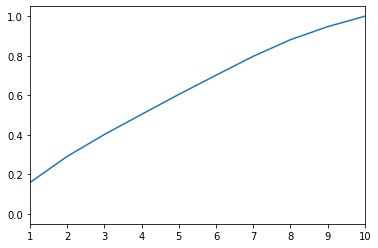

In [32]:
#  find optimal num components to use (n) by plotting explained variance ratio
cum_evr = np.insert(cum_evr, 0, 0, axis=0)
plt.xlim(1, 10)
plt.plot(cum_evr)

 We see from above that we reach ~80% of cummulative variance with the help of first 7 components. So now we will transform the data to 7 dimension

In [33]:
# We see from above that we reach ~80% of cummulative variance with the help of first 7 components. So now we will transform the data to 7 dimension

pca = PCA(n_components=7) #7 since 7 components explain 80% of variance
pca_fit = pca.fit_transform(x_scaled)

###4b. Test PCA use Linear Regression
Now we will run linear regression on PCA and non PCA data and compare the accuracy

In [34]:
#Linear regression
# Write a function that runs linear regression, prints return the results
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def run_linear_regression(X_train, X_test, y_train, y_test):
  print("\nRunnning linear regression")
  clf = LinearRegression()
  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)
  score = clf.score(X_test, y_pred)

  print("Score:", score)
  print('Mean Absolute Error (MAE): ', metrics.mean_absolute_error(y_test, y_pred))
  print("Mean Squared Error (MSE): ", metrics.mean_squared_error(y_test, y_pred))
  print("Root Mean Squared Error (RMSE): ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  return score, y_pred

Run different models on pca transformed data

In [36]:
# Split train and test data for PCA
from sklearn.model_selection import train_test_split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_fit, y, test_size = 0.2, random_state = 42)


Runnning linear regression
Score: 1.0
Mean Absolute Error (MAE):  107.59467612317317
Mean Squared Error (MSE):  23115.965820344452
Root Mean Squared Error (RMSE):  152.0393561560442


Text(0.5, 1.0, 'Linear Regression scatter plot using PCA')

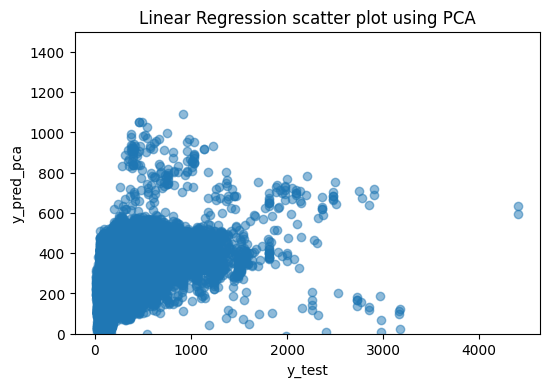

In [37]:
score, y_pred_pca = run_linear_regression(X_train_pca, X_test_pca, y_train_pca, y_test_pca)

plt.figure(dpi=100)
plt.scatter(y_test_pca, y_pred_pca, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred_pca")
plt.ylim(0,1500)
plt.title("Linear Regression scatter plot using PCA")

We see above that the linear regression model is not very accurate. It is spread across the diagonal line. We do see outliers.
This tells predicting flight prices is indeed hard problem :)  


Runnning linear regression
Score: 1.0
Mean Absolute Error (MAE):  100.38315380686585
Mean Squared Error (MSE):  20828.47896111419
Root Mean Squared Error (RMSE):  144.32075027907175


Text(0.5, 1.0, 'Linear Regression scatter plot without using PCA')

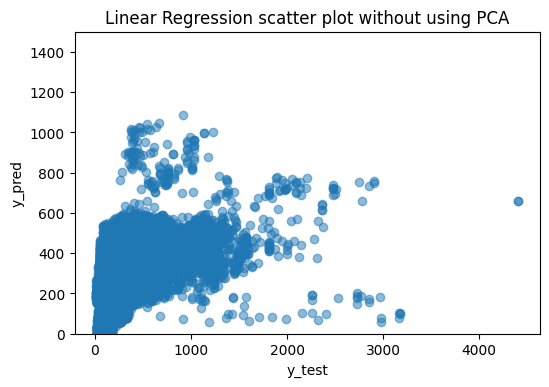

In [38]:
# Run the Regressor on non pca data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

score, y_pred = run_linear_regression(X_train, X_test, y_train, y_test)

plt.figure(dpi=100)
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.ylim(0,1500)
plt.title("Linear Regression scatter plot without using PCA")

We observe very similar graph using non pca data as compared to pca scaled data. There is very minor improvement in the accuracy of the model using non pca data

In [39]:
# We see that the linear regression without using PCA is giving better results. 
# Since the number of dimensions are not that many, we will continue to use the non PCA data for further analysis

###4c. Random Forest Regressor

In [40]:
# Run random forest regressor
from sklearn.ensemble import RandomForestRegressor
def run_random_forest_regressor(X_train, X_test, y_train, y_test, estimator, depth):
  print("\n Random Forest Regression. estimator: " + str(estimator) + ", depth: " + str(depth))
  reg_rf = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
  reg_rf.fit(X_train, y_train)
  y_pred = reg_rf.predict(X_test)

  #train score
  train_score = reg_rf.score(X_train, y_train)
  print("train score: ", train_score)

  #Test Score
  test_score = reg_rf.score(X_test, y_test)
  print("test score: ", test_score)
  return test_score, train_score, y_pred, reg_rf

In [ ]:
# Run random forest regressor for different conditions
#depths = [1, 2, 5, 8, 10, 12, 15, 18, 20, 21, 22, 23, 24, 25, 30, 35, 40, 45, 50]
depths = [20, 21, 23]
estimators = [1, 10, 15, 20, 30, 40, 50, 60]

model_accuracies = []
test_accuracies = []
y_preds = []

for estimator in estimators:
  model_acc = []
  test_acc = []
  for n in depths:
    result = run_random_forest_regressor(X_train, X_test, y_train, y_test, estimator, n)
    test_acc.append(result[0])
    model_acc.append(result[1])
    y_preds.append(result[2])
  model_accuracies.append(model_acc)
  test_accuracies.append(test_acc)

print(model_accuracies)
print(test_accuracies)


 estimator: 1, depth: 20
train score:  0.6742026986993364
test score:  0.4756410723155764

 estimator: 1, depth: 21
train score:  0.68496987630812
test score:  0.47385796469686203

 estimator: 1, depth: 23
train score:  0.692317361905753
test score:  0.43096593415964746

 estimator: 10, depth: 20
train score:  0.7765798887839281
test score:  0.6159203411921477

 estimator: 10, depth: 21
train score:  0.7919540312100272
test score:  0.6140904833058453

 estimator: 10, depth: 23
train score:  0.8147008089356668
test score:  0.5971681169454275

 estimator: 15, depth: 20
train score:  0.7811024233834887
test score:  0.6226252226560305

 estimator: 15, depth: 21
train score:  0.7954652086282068
test score:  0.6173064734306184

 estimator: 15, depth: 23
train score:  0.819560999536461
test score:  0.6052994150807718

 estimator: 20, depth: 20
train score:  0.7813062392221815
test score:  0.6263647592195762

 estimator: 20, depth: 21
train score:  0.798333510925824
test score:  0.61894682427

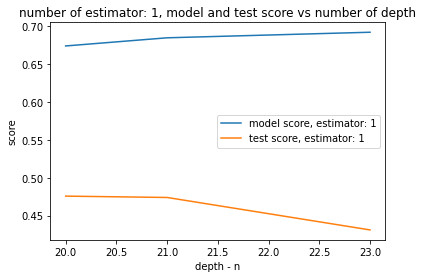

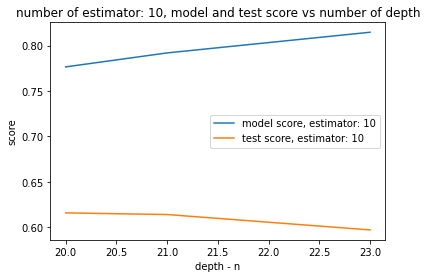

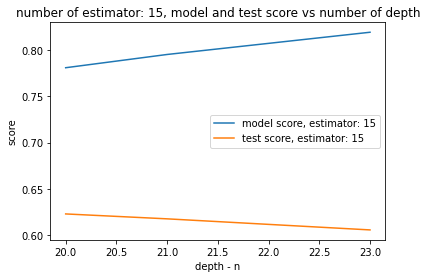

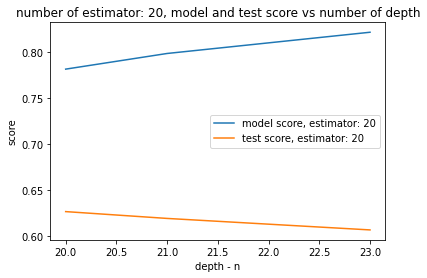

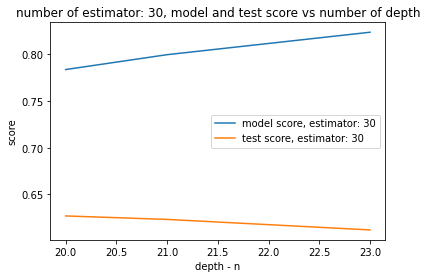

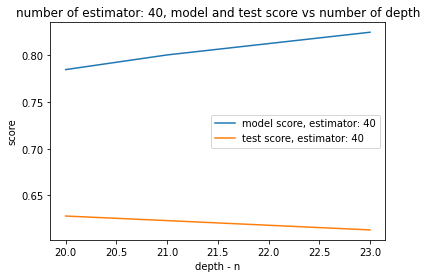

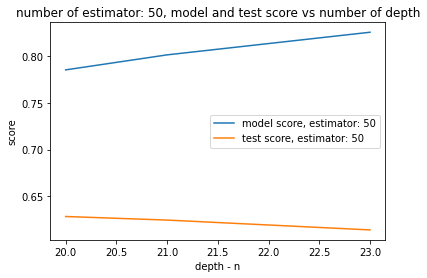

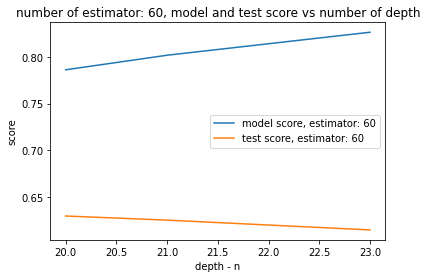

In [ ]:
#Random Forest Regressor Graph

for i in range(len(estimators)):
  plt.plot(depths, model_accuracies[i], label = "model score, estimator: " + str(estimators[i]))
  plt.plot(depths, test_accuracies[i], label = "test score, estimator: " + str(estimators[i]))
  plt.xlabel('depth - n')
  plt.ylabel('score')
  plt.title("number of estimator: " + str(estimators[i]) + ", model and test score vs number of depth")
  plt.legend()
  plt.show()

We see in the graphs above that the model in almost all the scenarios is overfitting slightly. For all the estimators, the test accuracy slowly improves with increasing the depth of the tree, it peaks and then it starts going down again.

In [ ]:
# Find the point with max score

max_so_far = 0
estimator = 0
depth = 0
i = 0
for test_acc in test_accuracies:
  max_acc = max(test_acc)
  if max_acc > max_so_far:
    max_so_far = max(max_so_far, max_acc)
    estimator = estimators[i]
    depth = depths[test_acc.index(max_acc)]
  i = i + 1

print("Random Tree Regressor Max score of: " + str(max_so_far) + ", at n_estimator: " + str(estimator) + ", depth: " + str(depth))

Random Tree Regressor Max score of: 0.6298084669589872, at n_estimator: 60, depth: 20



 Random Forest Regression. estimator: 60, depth: 20
train score:  0.7830020385618975
test score:  0.6993768299595136


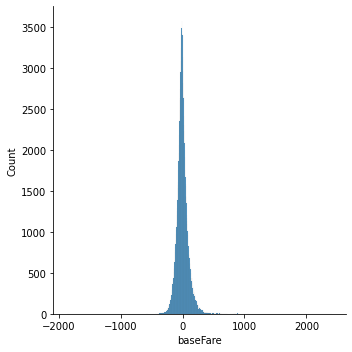

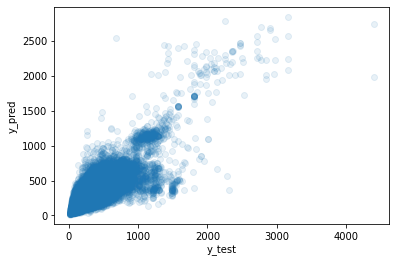

Mean Absolute Error (MAE):  67.27497707653268
Mean Squared Error (MSE):  9993.37093404616
Root Mean Squared Error (RMSE):  99.96684917534492


In [ ]:
# RandomForestRegressor graphs for best score
estimator = 60
depth = 20

result = run_random_forest_regressor(X_train, X_test, y_train, y_test, estimator, depth)
y_pred = result[2]
#Plot shows precision - majority of the values are close to zero 
sns.displot(y_test-y_pred)
plt.show()

#Scatter plot shows concentration on lower end - not the best model but reasonable
plt.scatter(y_test, y_pred, alpha = 0.1)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

# Checking accuracy through MSE, MAE AND RMSE using random forest model
from sklearn import metrics

print('Mean Absolute Error (MAE): ', metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE): ", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE): ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

The first distribution plot above provides how well the random forest regression is predicting the things. We see that majority of the points are concentrated at and near 0. This means model is doing good job at predicting flight price

The second scatter graph shows that random forest regressor is performing better than the linear regression

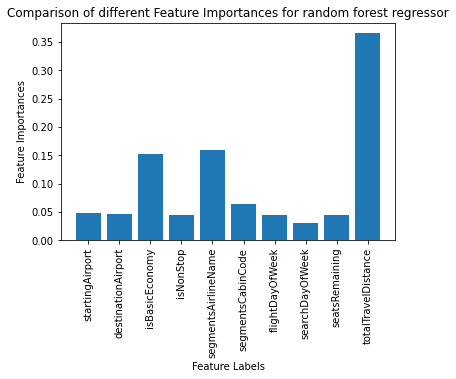

In [ ]:
# Feature importance in random forest regressor

# Plotting a Bar Graph to compare the models
# Shows importance of label features - most important is Total Travel Distance
plt.bar(X.columns, result[3].feature_importances_)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances for random forest regressor')
plt.xticks( rotation='vertical')
plt.show()

We see that among all the features, totalTravelDistance is the most important feature in predicting flight price. Then segmentAirlineName and isBasicEconomy. These features intuitively makes sense

###4d. Classification on the all flight data

In [ ]:
# Classification on all flights data
#avg fare per route
avg_base_fare_query = """Select startingAirport, destinationAirport, avg(baseFare) as avg_base_fare  FROM flight_df Group by startingAirport, destinationAirport order by avg(baseFare) desc, startingAirport asc, destinationAirport asc"""
avg_base_fare_df = sqldf(avg_base_fare_query, locals())
print(avg_base_fare_df.head(20))

   startingAirport destinationAirport  avg_base_fare
0              MIA                OAK     621.488677
1              OAK                MIA     609.391273
2              OAK                CLT     587.982893
3              LGA                OAK     584.127049
4              OAK                LGA     583.196834
5              IAD                OAK     582.973286
6              PHL                OAK     573.457633
7              OAK                PHL     571.949745
8              OAK                BOS     570.617707
9              CLT                OAK     570.272711
10             BOS                OAK     557.560975
11             OAK                DTW     553.304026
12             OAK                IAD     545.360137
13             DTW                OAK     543.002119
14             OAK                ATL     537.929396
15             OAK                ORD     535.844712
16             EWR                OAK     528.366240
17             OAK                EWR     526.

In [ ]:
#function finds average price and everything above and at that average is set to 1 or else set to 0
def get_avg(avg_fare_df, source, destination):
  #print("get_avg, source: " + source + ", destination: " + destination)
  return avg_fare_df[(avg_fare_df['startingAirport'] == str(source)) & (avg_fare_df['destinationAirport'] == str(destination))].iloc[0]['avg_base_fare']

def get_above_average(avg_fare_df, source, destination, baseFare):
  #print("source: " + source + ", destination: " + destination + ", baseFare: " + str(baseFare))
  avgFare = get_avg(avg_fare_df, source, destination)
  if  avgFare < baseFare:
    return 1
  return 0

In [ ]:
#applying above function 
flight_ml_classification_df = flight_ml_df.copy()
flight_ml_classification_df['above_average'] = flight_ml_classification_df.apply(lambda x: get_above_average(avg_base_fare_df, x.startingAirport, x.destinationAirport, x.baseFare), axis=1)


###4e. Check class imbalance


In [ ]:
# Check for class imbalance
print(len(flight_ml_classification_df[flight_ml_classification_df['above_average'] == 1]))
print(len(flight_ml_classification_df[flight_ml_classification_df['above_average'] == 0]))

334737
425843


-We see there is class imbalance between flights data where above_average is 1/0. The flights record where above_average is 0 is almost ~27% more than records where above_average is 1.

-We will now resample the records to make sure that both the classes are equally represented

In [ ]:
flight_ml_classification_df_above_avg_1 = flight_ml_classification_df[flight_ml_classification_df["above_average"] == 1]
flight_ml_classification_df_above_avg_0 = flight_ml_classification_df[flight_ml_classification_df["above_average"] == 0]

#only keep the number of samples as there are in above_average
flight_ml_classification_df_above_avg_0 = flight_ml_classification_df_above_avg_0.sample(n = len(flight_ml_classification_df_above_avg_1))

flight_ml_classification_df_resampled = pd.concat([flight_ml_classification_df_above_avg_1, flight_ml_classification_df_above_avg_0], axis = 0)

# shuffle the data frame
flight_ml_classification_df_resampled = flight_ml_classification_df_resampled.sample(frac = 1)

flight_ml_classification_df_resampled.reset_index(drop=True)

,startingAirport,destinationAirport,isBasicEconomy,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsAirlineName,segmentsCabinCode,flightDayOfWeek,searchDayOfWeek,above_average
0,LGA,ORD,False,True,92.09,113.60,7,720.0,American Airlines,coach,Friday,Monday,0
1,CLT,MIA,False,False,273.49,316.10,7,663.0,American Airlines||American Airlines,coach,Sunday,Friday,1
2,ATL,LAX,False,False,590.69,658.59,5,2074.0,United||United,coach,Sunday,Thursday,1
3,ATL,PHL,False,False,247.44,289.60,2,1612.0,American Airlines||American Airlines,coach,Monday,Thursday,1
4,LAX,DEN,False,False,213.95,253.60,7,916.0,American Airlines||American Airlines,coach,Monday,Tuesday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
669469,BOS,CLT,False,True,120.00,143.60,5,728.0,American Airlines,coach,Monday,Monday,0
669470,OAK,MIA,False,False,580.46,653.20,3,2674.0,Delta||Delta,coach,Saturday,Friday,0
669471,LGA,BOS,True,False,90.23,119.10,7,1273.0,American Airlines||American Airlines,coach,Saturday,Wednesday,0
669472,SFO,EWR,False,False,366.52,423.21,9,2883.0,United||United,coach,Tuesday,Thursday,0


In [ ]:
#Do the label encoding
flight_ml_classification_df_encoded = perform_label_encoding(flight_ml_classification_df_resampled)
flight_ml_classification_df_encoded.head()

,startingAirport,destinationAirport,isBasicEconomy,isNonStop,segmentsAirlineName,segmentsCabinCode,flightDayOfWeek,searchDayOfWeek,baseFare,totalFare,seatsRemaining,totalTravelDistance,above_average
467541,10,13,0,1,15,1,0,1,92.09,113.60,7,720.0,0
367462,2,11,0,0,16,1,3,0,273.49,316.10,7,663.0,1
118037,0,9,0,0,99,1,3,4,590.69,658.59,5,2074.0,1
88158,0,14,0,0,16,1,1,4,247.44,289.60,2,1612.0,1
780641,9,3,0,0,16,1,1,5,213.95,253.60,7,916.0,0


In [ ]:
#Create X and Y
X = flight_ml_classification_df_encoded.copy()
y = X['above_average']

# remove baseFare, totalFare and above_average from X
X.drop('baseFare', axis=1, inplace=True)
X.drop('totalFare', axis=1, inplace=True)
X.drop('above_average', axis=1, inplace=True)

X.head()

,startingAirport,destinationAirport,isBasicEconomy,isNonStop,segmentsAirlineName,segmentsCabinCode,flightDayOfWeek,searchDayOfWeek,seatsRemaining,totalTravelDistance
467541,10,13,0,1,15,1,0,1,7,720.0
367462,2,11,0,0,16,1,3,0,7,663.0
118037,0,9,0,0,99,1,3,4,5,2074.0
88158,0,14,0,0,16,1,1,4,2,1612.0
780641,9,3,0,0,16,1,1,5,7,916.0


In [ ]:
# Split into training and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [ ]:
#Run classification model on this dataset
# random forest classifier

# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier

def run_random_forest_classifier(X_train, X_test, y_train, y_test, estimators, depth):
  print("\nRandom Forest Classifier. estimators: " + str(estimators) + ", depth: " + str(depth))
  # creating a RF classifier
  clf = RandomForestClassifier(n_estimators = estimator, max_depth = depth)  
  
  # Training the model on the training dataset
  # fit function is used to train the model using the training sets as parameters
  clf.fit(X_train, y_train)
  
  # performing predictions on the test dataset
  y_pred = clf.predict(X_test)
  y_train_pred = clf.predict(X_train)
  
  # metrics are used to find accuracy or error
  from sklearn import metrics  
  print()
  test_accuracy = metrics.accuracy_score(y_test, y_pred)
  training_accuracy = metrics.accuracy_score(y_train, y_train_pred)
  # using metrics module for accuracy calculation
  print("TEST ACCURACY OF THE MODEL: ", test_accuracy )
  print("TRAINING ACCURACY OF THE MODEL: ", training_accuracy)
  return test_accuracy, training_accuracy, clf

In [ ]:
#Run classification model on this dataset
# random forest classifier
#Decision Tree Classifier Depth tests
#depths = [1, 2, 5, 8, 10, 12, 15, 18, 20, 21, 22, 23, 24, 25, 30, 35, 40, 45, 50]
depths = [1, 5, 10, 15, 20, 25, 30]
estimators = [1, 5, 10, 15, 20, 25, 30]

model_accuracies = []
test_accuracies = []
clfs = []

for estimator in estimators:
  model_acc = []
  test_acc = []
  for n in depths:
    result = run_random_forest_classifier(X_train, X_test, y_train, y_test, estimator, n)
    test_acc.append(result[0])
    model_acc.append(result[1])
  model_accuracies.append(model_acc)
  test_accuracies.append(test_acc)

print(model_accuracies)
print(test_accuracies)


Random Forest Classifier. estimators: 1, depth: 1

TEST ACCURACY OF THE MODEL:  0.6260427947272116
TRAINING ACCURACY OF THE MODEL:  0.6232488577782176

Random Forest Classifier. estimators: 1, depth: 5

TEST ACCURACY OF THE MODEL:  0.6636767616415848
TRAINING ACCURACY OF THE MODEL:  0.6601229697206201

Random Forest Classifier. estimators: 1, depth: 10

TEST ACCURACY OF THE MODEL:  0.6791366369169872
TRAINING ACCURACY OF THE MODEL:  0.6797223192096777

Random Forest Classifier. estimators: 1, depth: 15

TEST ACCURACY OF THE MODEL:  0.71367862877628
TRAINING ACCURACY OF THE MODEL:  0.7301387843810156

Random Forest Classifier. estimators: 1, depth: 20

TEST ACCURACY OF THE MODEL:  0.7152395533813809
TRAINING ACCURACY OF THE MODEL:  0.7747316455648933

Random Forest Classifier. estimators: 1, depth: 25

TEST ACCURACY OF THE MODEL:  0.7033496396430039
TRAINING ACCURACY OF THE MODEL:  0.8145091573792101

Random Forest Classifier. estimators: 1, depth: 30

TEST ACCURACY OF THE MODEL:  0.70

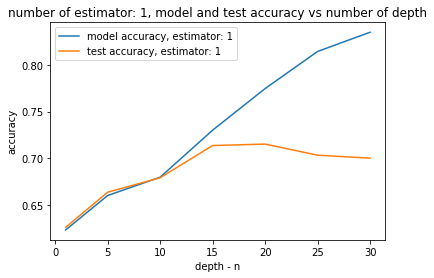

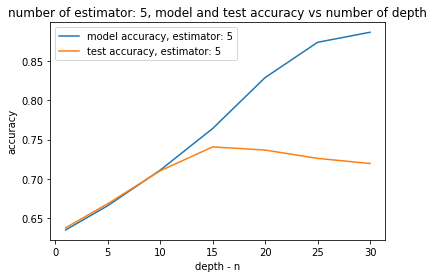

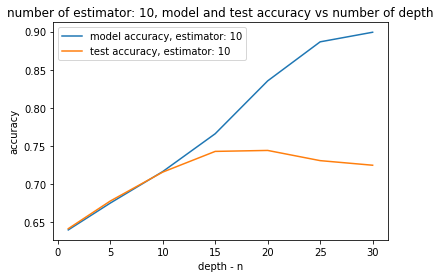

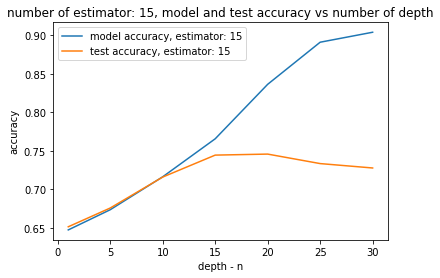

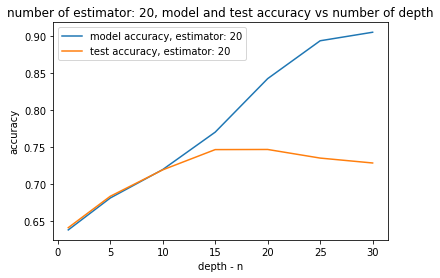

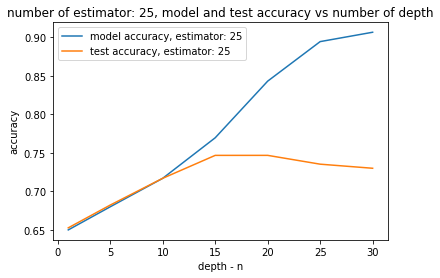

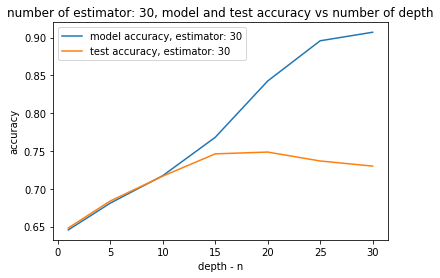

In [ ]:
#Random Forest Classifier Graph

for i in range(len(estimators)):
  plt.plot(depths, model_accuracies[i], label = "model accuracy, estimator: " + str(estimators[i]))
  plt.plot(depths, test_accuracies[i], label = "test accuracy, estimator: " + str(estimators[i]))
  plt.xlabel('depth - n')
  plt.ylabel('accuracy')
  plt.title("number of estimator: " + str(estimators[i]) + ", model and test accuracy vs number of depth")
  plt.legend()
  plt.show()

We see in all the graphs above that for any number of estimator, increasing the depth of the tree is linearly related to improving the training model accuracy. But the test accuracy only increases upto a certain value of depth, and then actually starts decreasing.

This tells that increasing depth mindlessly will lead to overfitting.
This also signifies the importance of hyper parameter tuning, in order to find the right set of parameters

In [ ]:
# Find the point with max accuracy

max_so_far = 0
estimator = 0
depth = 0
i = 0
for test_acc in test_accuracies:
  max_acc = max(test_acc)
  if max_acc > max_so_far:
    max_so_far = max(max_so_far, max_acc)
    estimator = estimators[i]
    depth = depths[test_acc.index(max_acc)]
  i = i + 1

print("Random Forest Classifier Max accuracy of: " + str(max_so_far) + ", at n_estimator: " + str(estimator) + ", depth: " + str(depth))

Random Tree Classifier Max accuracy of: 0.7485417678031293, at n_estimator: 30, depth: 20


In [ ]:
# Run random forest classifier for the best score parameters and plot graph
print("\n The best random forest classifier results: ")
result = run_random_forest_classifier(X_train, X_test, y_train, y_test, 30, 20)


 The best random forest classifier results: 

Random Forest Classifier. estimators: 30, depth: 20

TEST ACCURACY OF THE MODEL:  0.7480040330109414
TRAINING ACCURACY OF THE MODEL:  0.8424863558877402


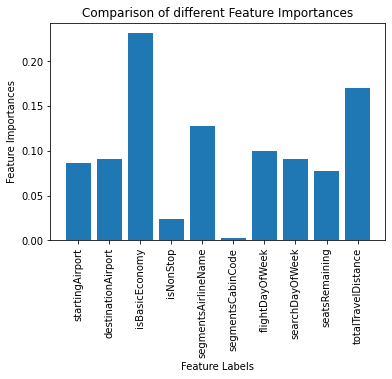

In [ ]:
# Feature importance

# Plotting a Bar Graph to compare the models
# Shows importance of label features - most important is Total Travel Distance
plt.bar(X.columns, result[2].feature_importances_)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.xticks( rotation='vertical')
plt.show()

We see above that for the classification problem isBasicEconomy is the most important feature (in regression above, it was totalTravelDistance). The second and third are totalTravelDistance and segmentAirlineName. This makes sense intuitively

###4f. Decision Tree Classification 
- Above Random Forest Classification was performed. We will try to run the decision tree classifier and see how that performs 

In [ ]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

def run_decision_tree_classifier(X_train, X_test, y_train, y_test, criteria, depth):
  print("\n Decision Tree Classifier. criteria: " + criteria + ", depth: " + str(depth))
  # Create Decision Tree classifer object
  clf = DecisionTreeClassifier(criterion=criteria, max_depth=depth)

  # Training the model on the training dataset
  # fit function is used to train the model using the training sets as parameters
  clf.fit(X_train, y_train)
  
  # performing predictions on the test dataset
  y_pred = clf.predict(X_test)
  y_train_pred = clf.predict(X_train)
  
  # metrics are used to find accuracy or error  
  print()
  
  # using metrics module for accuracy calculation
  test_accuracy = metrics.accuracy_score(y_test, y_pred)
  training_accuracy = metrics.accuracy_score(y_train, y_train_pred)
  print("ACCURACY OF THE MODEL: ", test_accuracy )
  print("ACCURACY OF TRAINING THE MODEL: ", training_accuracy )
  return test_accuracy, training_accuracy, clf

In [ ]:
#Decision Tree Classifier Depth tests
depths = [1, 2, 5, 8, 10, 12, 15, 18, 20, 21, 22, 23, 24, 25, 30, 35, 40, 45, 50]

gini_model_accuracies = []
gini_test_accuracies = []

entropy_model_accuracies = []
entropy_test_accuracies = []

for n in depths:
  result = run_decision_tree_classifier(X_train, X_test, y_train, y_test, "gini", n)
  gini_test_accuracies.append(result[0])
  gini_model_accuracies.append(result[1])

print(gini_model_accuracies)
print(gini_test_accuracies)

for n in depths:
  result = run_decision_tree_classifier(X_train, X_test, y_train, y_test, "entropy", n)
  entropy_test_accuracies.append(result[0])
  entropy_model_accuracies.append(result[1])

print(entropy_model_accuracies)
print(entropy_test_accuracies)


 Decision Tree Classifier. criteria: gini, depth: 1

ACCURACY OF THE MODEL:  0.6260427947272116
ACCURACY OF TRAINING THE MODEL:  0.6232488577782176

 Decision Tree Classifier. criteria: gini, depth: 2

ACCURACY OF THE MODEL:  0.6466410246835207
ACCURACY OF TRAINING THE MODEL:  0.6438023148779172

 Decision Tree Classifier. criteria: gini, depth: 5

ACCURACY OF THE MODEL:  0.6730871205048732
ACCURACY OF TRAINING THE MODEL:  0.6705173279758915

 Decision Tree Classifier. criteria: gini, depth: 8

ACCURACY OF THE MODEL:  0.7024235408342357
ACCURACY OF TRAINING THE MODEL:  0.7018086967562208

 Decision Tree Classifier. criteria: gini, depth: 10

ACCURACY OF THE MODEL:  0.7149632174465066
ACCURACY OF TRAINING THE MODEL:  0.715950401341352

 Decision Tree Classifier. criteria: gini, depth: 12

ACCURACY OF THE MODEL:  0.7286978602636395
ACCURACY OF TRAINING THE MODEL:  0.734205411339877

 Decision Tree Classifier. criteria: gini, depth: 15

ACCURACY OF THE MODEL:  0.7377796034205908
ACCURACY

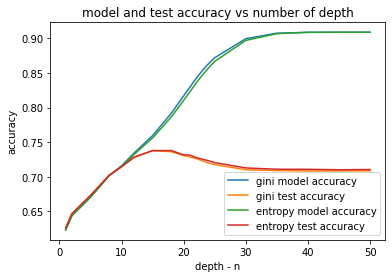

In [ ]:
#Decision Tree Classifier Graph

plt.plot(depths, gini_model_accuracies, label = "gini model accuracy")
plt.plot(depths, gini_test_accuracies, label = "gini test accuracy")
plt.plot(depths, entropy_model_accuracies, label = "entropy model accuracy")
plt.plot(depths, entropy_test_accuracies, label = "entropy test accuracy")
plt.xlabel('depth - n')
plt.ylabel('accuracy')
plt.title('model and test accuracy vs number of depth')
plt.legend()
plt.show()

We tried both the criterias - gini and entropy against multiple different depths.
We observe that entropy slights performs better than gini at all the depths. Also similar to what we observe with random forest classifier, we see the overfitting problem as the depth keeps increasing. Also, test accuracy increases and peaks at a particular point and then starts decreasing with increasing depth.

In [ ]:
# Identify best model
max_gini = max(gini_test_accuracies)
max_entropy = max(entropy_test_accuracies)

print("Max gini test accuracy is: " + str(max_gini) + ". The depth of the model is: " + str(depths[gini_test_accuracies.index(max_gini)]))
print("Max entropy test accuracy is: " + str(max_entropy) + ". The depth of the model is: " + str(depths[entropy_test_accuracies.index(max_entropy)]))

Max gini test accuracy is: 0.7377796034205908. The depth of the model is: 15
Max entropy test accuracy is: 0.7378916315022965. The depth of the model is: 15


In [ ]:
# We observe that the entropy model has slightly higher accuracy than the gini model. 
# Both the decision tree models reaches respective peak accuracy at depth of 18

###4g. Run PCA with Decision Tree Classification

* We will run the Decision Tree Classification on the PCA scaled dataset and see how it performs compared to non pca dataset that was run above

In [ ]:
# Run the decision tree classifier with PCA scaled and observe the accuracy

# do pca again
# Instantiate and Fit PCA
x_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=7) #7 since 7 components explain 80% of variance
X = pca.fit_transform(x_scaled)

# Split into training and test dataset
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X, y, test_size = 0.2, random_state = 42)

#Decision Tree Classifier Depth tests
depths = [1, 2, 5, 8, 10, 12, 15, 18, 20, 21, 22, 23, 24, 25, 30, 35, 40, 45, 50]

gini_model_accuracies = []
gini_test_accuracies = []

entropy_model_accuracies = []
entropy_test_accuracies = []

for n in depths:
  result = run_decision_tree_classifier(X_train_pca, X_test_pca, y_train_pca, y_test_pca, "gini", n)
  gini_test_accuracies.append(result[0])
  gini_model_accuracies.append(result[1])

print(gini_model_accuracies)
print(gini_test_accuracies)

for n in depths:
  result = run_decision_tree_classifier(X_train_pca, X_test_pca, y_train_pca, y_test_pca, "entropy", n)
  entropy_test_accuracies.append(result[0])
  entropy_model_accuracies.append(result[1])

print(entropy_model_accuracies)
print(entropy_test_accuracies)


 Decision Tree Classifier. criteria: gini, depth: 1

ACCURACY OF THE MODEL:  0.5966839687815079
ACCURACY OF TRAINING THE MODEL:  0.5953668833169337

 Decision Tree Classifier. criteria: gini, depth: 2

ACCURACY OF THE MODEL:  0.6321221852944472
ACCURACY OF TRAINING THE MODEL:  0.6309788098487805

 Decision Tree Classifier. criteria: gini, depth: 5

ACCURACY OF THE MODEL:  0.6396878150789798
ACCURACY OF TRAINING THE MODEL:  0.6383764113230728

 Decision Tree Classifier. criteria: gini, depth: 8

ACCURACY OF THE MODEL:  0.6550580678890175
ACCURACY OF TRAINING THE MODEL:  0.65507796235476

 Decision Tree Classifier. criteria: gini, depth: 10

ACCURACY OF THE MODEL:  0.6645132379849883
ACCURACY OF TRAINING THE MODEL:  0.6690777644381127

 Decision Tree Classifier. criteria: gini, depth: 12

ACCURACY OF THE MODEL:  0.6716008812875761
ACCURACY OF TRAINING THE MODEL:  0.6840522126521017

 Decision Tree Classifier. criteria: gini, depth: 15

ACCURACY OF THE MODEL:  0.6828783748459614
ACCURACY

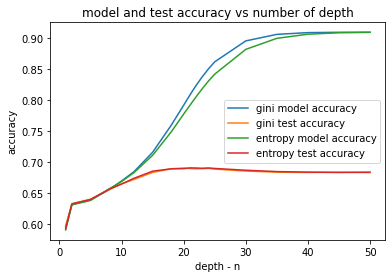

In [ ]:
#Decision Tree Classifier Graph with PCA

plt.plot(depths, gini_model_accuracies, label = "gini model accuracy")
plt.plot(depths, gini_test_accuracies, label = "gini test accuracy")
plt.plot(depths, entropy_model_accuracies, label = "entropy model accuracy")
plt.plot(depths, entropy_test_accuracies, label = "entropy test accuracy")
plt.xlabel('depth - n')
plt.ylabel('accuracy')
plt.title('model and test accuracy vs number of depth')
plt.legend()
plt.show()

We observe very similar trends running decision tree classifier on the pca dataset as we with running on non pca dataset.

We also see that the max test accuracy of the model on the pca scaled dataset is lower than the non pca dataset

In [ ]:
# Identify best model with PCA
max_gini = max(gini_test_accuracies)
max_entropy = max(entropy_test_accuracies)

print("Max gini test accuracy is: " + str(max_gini) + ". The depth of the model is: " + str(depths[gini_test_accuracies.index(max_gini)]))
print("Max entropy test accuracy is: " + str(max_entropy) + ". The depth of the model is: " + str(depths[entropy_test_accuracies.index(max_entropy)]))

Max gini test accuracy is: 0.6899734866873296. The depth of the model is: 20
Max entropy test accuracy is: 0.6901975428507413. The depth of the model is: 21


###4h. Summary of PCA usage

-We did test PCA with linear regressor and decision tree clasifier.
Both the models, with the same non PCA data, has higher test accuracy.

-So, we won't use PCA scaled data moving further.

##5. Model and Split NonStop and MultiStop flights for prediction

We observed above that totalTravelDistance plays a big role in regression.
Given that in real world, people often search by stop vs non-stops flights, we would want to see whether training / testing specifically on nonStop and multi stop flights help us give better results

In [ ]:
#Split nonstop and multistop 
flight_nonstop_df = flight_df[flight_df['isNonStop'] == True]
flight_stop_df = flight_df[flight_df['isNonStop'] == False]
#print(flight_df[["isNonStop"]].head())
print(len(flight_df))
print(len(flight_nonstop_df))
print(len(flight_stop_df))


760580
212714
547866


Install required libraries

In [ ]:
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libkrb5-dev is already the newest version (1.16-2ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
--2022-12-17 08:25:10--  https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.214.104, 2a01:4f8:10a:201a::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-12-17 08:25:10 ERROR 404: Not Found.

tar: spark-3.1.2-bin-hadoop3.2.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: http

###5a. With Spark

In [ ]:
#Trying out spark

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('cis545-khyatisa-project').getOrCreate()

try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

In [ ]:
# convert pandas dataframe to spark dataframe
# flight_nonstop_sdf=spark.createDataFrame(pandasDF) 
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

In [ ]:
def perform_hot_encoding(input_df):
  input_df_copy = input_df.copy() 
  categorical_data = input_df_copy.select_dtypes(exclude=['int64', 'float','int32'])
  numerical_data = input_df_copy.select_dtypes(include=['int64', 'float','int32'])

  encoder = OneHotEncoder()
  for column in categorical_data.columns:
    onehotarray = encoder.fit_transform(categorical_data[[column]]).toarray()
    items = [f'{column}_{item}' for item in encoder.categories_[0]]
    categorical_data[items] = onehotarray
    categorical_data.drop(column, axis=1, inplace=True)

  input_df_copy = pd.concat([categorical_data, numerical_data], axis=1)
  input_df_copy.reset_index(drop=True)
  return input_df_copy

In [ ]:
# Running below crashses due to running low on RAM. avoid hot encoding on large data

#flight_nonstop_df_hotencoded = perform_hot_encoding(flight_nonstop_df)
#flight_nonstop_df_hotencoded.head()

Text(0.5, 1.0, 'Non_Stop_Flight_Prices Correlation')

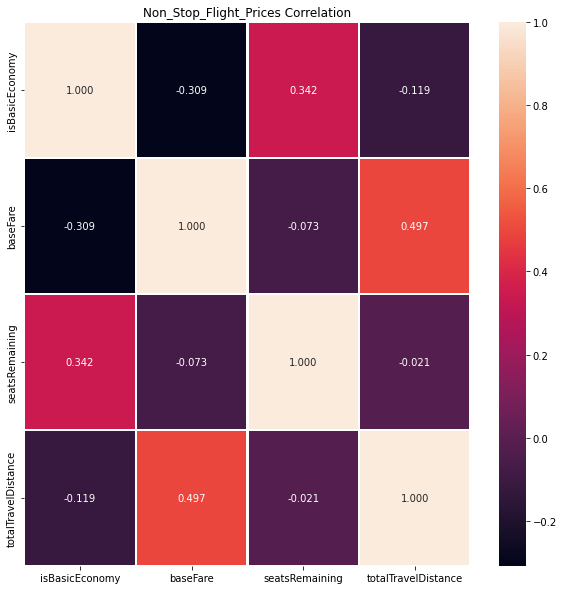

In [ ]:
#Try out label encoding methods
mlFeatureColumns = ['startingAirport', 'destinationAirport', 'isBasicEconomy', 'baseFare', 'seatsRemaining', 'totalTravelDistance', 'segmentsAirlineName', 'flightDayOfWeek', 'searchDayOfWeek']
flight_nonstop_ml_df = flight_nonstop_df[mlFeatureColumns]
fig, ax = plt.subplots(figsize=(10,10)) 

sns.heatmap(flight_nonstop_ml_df.corr(), annot=True, linewidths= 1.5, ax = ax, fmt='.3f')
ax.set_title('Non_Stop_Flight_Prices Correlation')


We see that baseFare is correlated to totalTravelDistance (+ve) and isBasicEconomy(-ve) for non stop data

In [ ]:
# Try label encoding with nonStop flights data
mlFeatureColumnsStopNonStop = mlFeatureColumns.copy()
mlFeatureColumnsStopNonStop.remove('isNonStop')
mlFeatureColumnsStopNonStop.remove('totalFare')

flight_nonstop_df_encoded = perform_label_encoding(flight_nonstop_df[mlFeatureColumnsStopNonStop])
flight_nonstop_df_encoded.head()

,startingAirport,destinationAirport,isBasicEconomy,segmentsAirlineName,flightDayOfWeek,searchDayOfWeek,baseFare,seatsRemaining,totalTravelDistance
0,0,4,0,2,3,2,174.88,8,725.0
4,0,14,0,1,3,2,1500.47,1,667.0
7,1,10,0,1,3,2,254.22,7,185.0
10,2,4,0,1,3,2,237.21,7,930.0
11,2,7,0,1,3,2,238.14,1,327.0


Text(0.5, 1.0, 'Non_Stop_Flight_Prices Correlation')

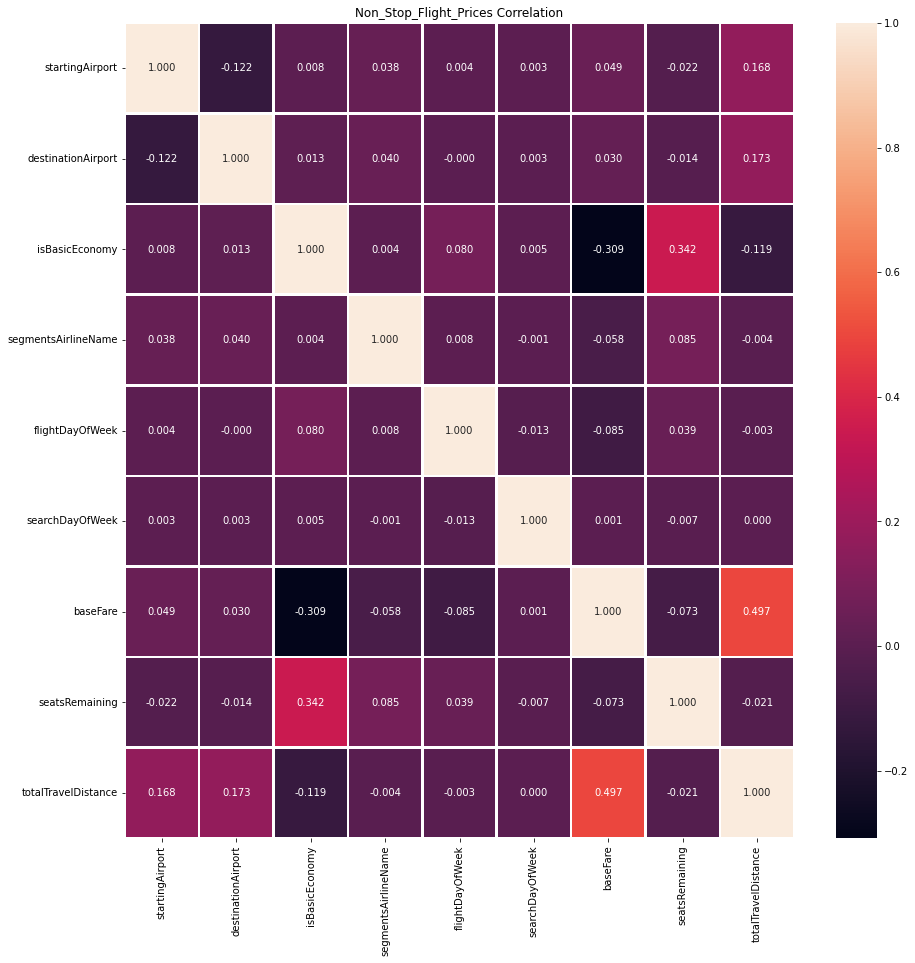

In [ ]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(flight_nonstop_df_encoded.corr(), annot=True, linewidths= 1.5, ax = ax, fmt='.3f')
ax.set_title('Non_Stop_Flight_Prices Correlation')

We observe similar correlation trends with non stops flight data as we saw with all flights data.

In [ ]:
# Create X and Y
X = flight_nonstop_df_encoded.copy()
X.reset_index(drop=True)
y = X['baseFare']

X.head()
X.drop('baseFare', axis=1, inplace=True)

In [ ]:
print(X.head())

    startingAirport  destinationAirport  isBasicEconomy  segmentsAirlineName  \
0                 0                   4               0                    2   
4                 0                  14               0                    1   
7                 1                  10               0                    1   
10                2                   4               0                    1   
11                2                   7               0                    1   

    flightDayOfWeek  searchDayOfWeek  seatsRemaining  totalTravelDistance  
0                 3                2               8                725.0  
4                 3                2               1                667.0  
7                 3                2               7                185.0  
10                3                2               7                930.0  
11                3                2               1                327.0  


###5b. Try Extra Tree Regressor method- Ensemble Technique like random tree methodcreates many decision trees, but the sampling for each tree is random without replacement

In [ ]:
#ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor

etg = ExtraTreesRegressor()
etg.fit(X, y)

ExtraTreesRegressor()

[0.04605143 0.04476982 0.11829053 0.06571208 0.08393569 0.13159885
 0.09767568 0.41196591]


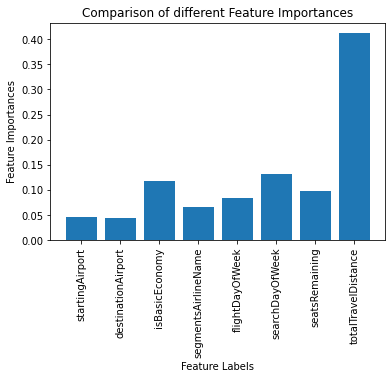

In [ ]:
print(etg.feature_importances_)
# Plotting a Bar Graph to compare the models
# Shows importance of label features - most important is Total Travel Distance
plt.bar(X.columns, etg.feature_importances_)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.xticks( rotation='vertical')
plt.show()

We observe here that totalTravelDistance is still the most important feature in extra tree regressor for non stop flights data

In [ ]:
#split test train 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
#Extra Tree Regressor accuracy scores
etg.fit(X_train, y_train)
y_pred = etg.predict(X_test)
print(etg.score(X_train, y_train))
print(etg.score(X_test, y_test))

print('Mean Absolute Error (MAE): ', metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE): ", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE): ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.731323456073529
0.2873489884986873
Mean Absolute Error (MAE):  71.12830269683526
Mean Squared Error (MSE):  16875.986736252544
Root Mean Squared Error (RMSE):  129.90760846175462


###5c. Random Forest Regression on NonStop Flight Data

In [ ]:
# Run random forest regressor for different conditions
#depths = [1, 2, 5, 8, 10, 12, 15, 18, 20, 21, 22, 23, 24, 25, 30, 35, 40, 45, 50]
depths = [20, 21, 23]
estimators = [1, 10, 15, 20, 30, 40, 50, 60]

model_accuracies = []
test_accuracies = []
y_preds = []

for estimator in estimators:
  model_acc = []
  test_acc = []
  for n in depths:
    result = run_random_forest_regressor(X_train, X_test, y_train, y_test, estimator, n)
    test_acc.append(result[0])
    model_acc.append(result[1])
    y_preds.append(result[2])
  model_accuracies.append(model_acc)
  test_accuracies.append(test_acc)

print(model_accuracies)
print(test_accuracies)



 Random Forest Regression. estimator: 1, depth: 20
train score:  0.6282786816598747
test score:  0.41968802843554653

 Random Forest Regression. estimator: 1, depth: 21
train score:  0.6318373106587913
test score:  0.39027349078599594

 Random Forest Regression. estimator: 1, depth: 23
train score:  0.6332287888217532
test score:  0.3924767889905755

 Random Forest Regression. estimator: 10, depth: 20
train score:  0.7237881580591541
test score:  0.5512700604592777

 Random Forest Regression. estimator: 10, depth: 21
train score:  0.7301856737732202
test score:  0.5434853669793973

 Random Forest Regression. estimator: 10, depth: 23
train score:  0.7386987629916211
test score:  0.52590090038107

 Random Forest Regression. estimator: 15, depth: 20
train score:  0.7265879363647332
test score:  0.5612040697664633

 Random Forest Regression. estimator: 15, depth: 21
train score:  0.7340552514863806
test score:  0.5445446529533667

 Random Forest Regression. estimator: 15, depth: 23
train 

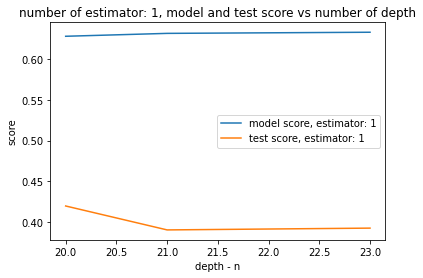

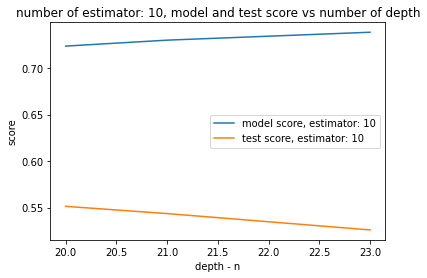

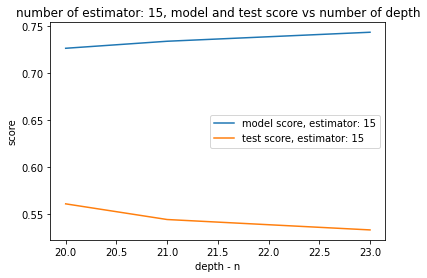

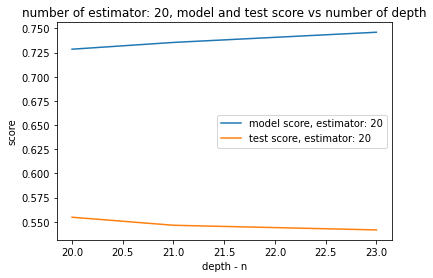

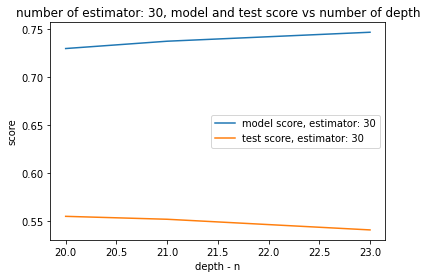

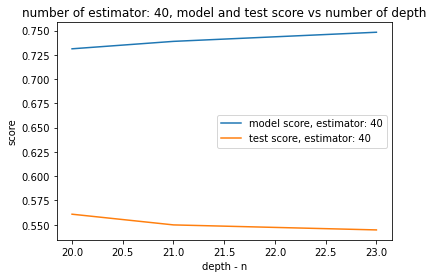

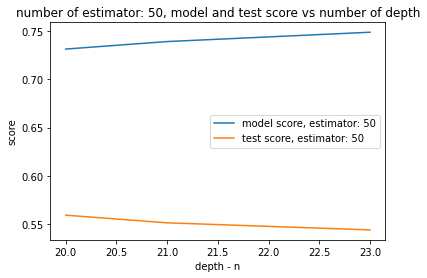

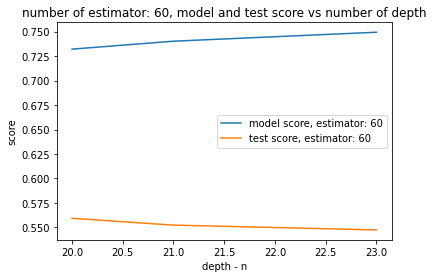

In [ ]:
#Random Forest Regressor Graph

for i in range(len(estimators)):
  plt.plot(depths, model_accuracies[i], label = "model score, estimator: " + str(estimators[i]))
  plt.plot(depths, test_accuracies[i], label = "test score, estimator: " + str(estimators[i]))
  plt.xlabel('depth - n')
  plt.ylabel('score')
  plt.title("number of estimator: " + str(estimators[i]) + ", model and test score vs number of depth")
  plt.legend()
  plt.show()

We observe similar trens with random forest regression on nonstop flight data as we observed with all flights data. the test accuracy increases to certain point upon increasing depth and then it starts decreasing

In [ ]:
# Find the point with max score

max_so_far = 0
estimator = 0
depth = 0
i = 0
for test_acc in test_accuracies:
  max_acc = max(test_acc)
  if max_acc > max_so_far:
    max_so_far = max(max_so_far, max_acc)
    estimator = estimators[i]
    depth = depths[test_acc.index(max_acc)]
  i = i + 1

print("Random Tree Regressor Max score of: " + str(max_so_far) + ", at n_estimator: " + str(estimator) + ", depth: " + str(depth))


Random Tree Regressor Max score of: 0.5612040697664633, at n_estimator: 15, depth: 20



 Random Forest Regression. estimator: 15, depth: 20
train score:  0.7257773275064199
test score:  0.5567554685651024


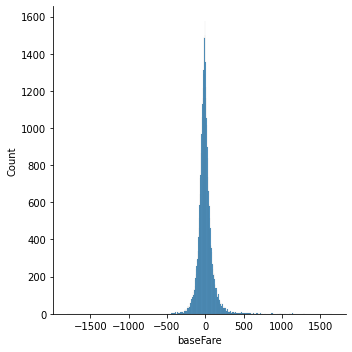

In [ ]:
# RandomForestRegressor graphs for best score
estimator = 15
depth = 20

result = run_random_forest_regressor(X_train, X_test, y_train, y_test, estimator, depth)
y_pred = result[2]
#Plot shows precision - majority of the values are close to zero 
sns.displot(y_test-y_pred)
plt.show()

We see from above that the distribution plot of difference between predicted and actual values gives a good curve centered around 0. This means the model is doing a good job at predicting flight prices

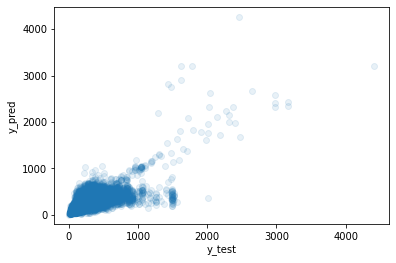

In [ ]:
#Scatter plot shows concentration on lower end - not the best model but reasonable
plt.scatter(y_test, y_pred, alpha = 0.1)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()


We see that there are some outliers above, but apart from that, model is doing a good job at predicting flight prices

In [ ]:
# Checking accuracy through MSE, MAE AND RMSE using random forest model
from sklearn import metrics

print('Mean Absolute Error (MAE): ', metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE): ", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE): ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error (MAE):  63.31906996327147
Mean Squared Error (MSE):  10496.28599790183
Root Mean Squared Error (RMSE):  102.45138358217439


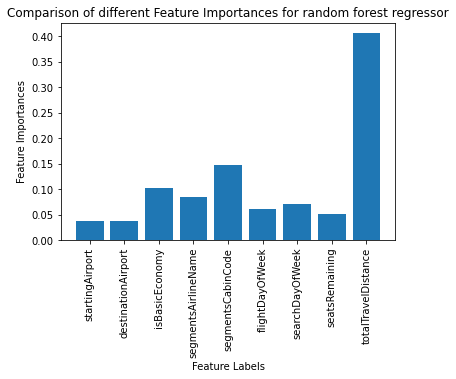

In [ ]:
# Feature importance in random forest regressor

# Plotting a Bar Graph to compare the models
# Shows importance of label features - most important is Total Travel Distance
plt.bar(X.columns, result[3].feature_importances_)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances for random forest regressor')
plt.xticks( rotation='vertical')
plt.show()

We again see that totalTravelDistance is the most important feature in this regression model

###5d. Linear Regression: non-stop 


Runnning linear regression
Score: 1.0
Mean Absolute Error (MAE):  76.55986153025775
Mean Squared Error (MSE):  15481.254481705837
Root Mean Squared Error (RMSE):  124.42368939115187


(0.0, 1500.0)

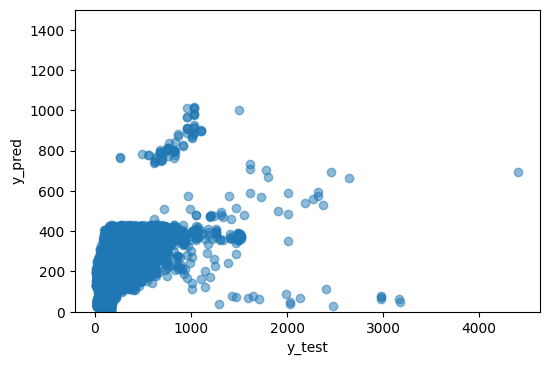

In [ ]:
#Linear regression

result = run_linear_regression(X_train, X_test, y_train, y_test)

y_pred = result[1]
score = result[0]

plt.figure(dpi=100)
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.ylim(0,1500)

We see that linear regression on the non stop flight data performs worse than the random forest regression.

###5e. Regularized Linear Regression: non-stop

In [ ]:
# Ridge regression

from sklearn.linear_model import Ridge

# Your code here
clf = Ridge()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

ridge_score = clf.score(X_test, y_pred)

print("Score:", clf.score(X_test, y_test))

print('Mean Absolute Error (MAE): ', metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE): ", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE): ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2: ", metrics.r2_score(y_test, y_pred))

Score: 0.34624661078860297
Mean Absolute Error (MAE):  76.55995413269451
Mean Squared Error (MSE):  15481.257090857802
Root Mean Squared Error (RMSE):  124.42369987609997
R2:  0.34624661078860297


In [ ]:
# Try SDF and apply concepts from class and assignments
flight_nonstop_sdf = X.copy()
flight_nonstop_sdf['baseFare'] = y

#convert pandas dataframe to spark dataframe
flight_nonstop_sdf=spark.createDataFrame(flight_nonstop_sdf) 

#####Create Pipeline


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
#on sdf
assembler = VectorAssembler(inputCols=X.columns.values.tolist(), outputCol="features")

pipe = Pipeline(stages=[assembler])

model = pipe.fit(flight_nonstop_sdf)
modified_data_sdf = model.transform(flight_nonstop_sdf)

In [ ]:
# TO-DO: Do 80/20 train-test split with seed = 24
train_sdf, test_sdf = modified_data_sdf.randomSplit([0.8, 0.2], seed = 24)

In [ ]:
print(test_sdf.head())

Row(startingAirport=0, destinationAirport=1, isBasicEconomy=0, segmentsAirlineName=1, flightDayOfWeek=5, searchDayOfWeek=1, seatsRemaining=7, totalTravelDistance=947.0, baseFare=124.65, features=DenseVector([0.0, 1.0, 0.0, 1.0, 5.0, 1.0, 7.0, 947.0]))


#####Regularized Regression using sdf
######-Lasso, Ridge, and Elastic

In [ ]:
from pyspark.ml.classification import LogisticRegression


from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# TO-DO: LASSO/L1 regularized model's AUC ROC score and save to "test_area_l1" 

#test_area_l1

l1 = LinearRegression(featuresCol="features", labelCol="baseFare", predictionCol="rawPrediction", maxIter=100,regParam=0.3, elasticNetParam=1.0, fitIntercept=True, standardization=True)
model = l1.fit(train_sdf)
predictions = model.transform(test_sdf)
evaluator = RegressionEvaluator(predictionCol="rawPrediction", labelCol="baseFare", metricName='rmse')
test_area_l1 =  (evaluator.evaluate(predictions))
print("LASSO - RMSE - Root mean square error: " + str(test_area_l1))

l2 = LinearRegression(featuresCol="features", labelCol="baseFare", predictionCol="rawPrediction", maxIter=100,regParam=0.3, elasticNetParam=0.8, fitIntercept=True, standardization=True)
model = l2.fit(train_sdf)
predictions = model.transform(test_sdf)
evaluator = RegressionEvaluator(predictionCol="rawPrediction", labelCol="baseFare", metricName='rmse')
test_area_l2 =  (evaluator.evaluate(predictions))
print("Ridge - RMSE - Root mean square error: " + str(test_area_l2))

elastic = LinearRegression(featuresCol="features", labelCol="baseFare", predictionCol="rawPrediction", maxIter=100,regParam=0.5, elasticNetParam=0.0, fitIntercept=True, standardization=True)
model = elastic.fit(train_sdf)
predictions = model.transform(test_sdf)
evaluator = RegressionEvaluator(predictionCol="rawPrediction", labelCol="baseFare", metricName='rmse')
test_area_elastic =  (evaluator.evaluate(predictions))
print("Elastic - RMSE - Root mean square error: " + str(test_area_elastic))


LASSO - RMSE - Root mean square error: 126.5504233345579
Ridge - RMSE - Root mean square error: 126.5499269766887
Elastic - RMSE - Root mean square error: 126.54887258503594


#####PCA- trying to understand if the feature selection process was correct above


In [ ]:
# PCA on normal data

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# Instantiate and Fit PCA
x_train_scaled = StandardScaler().fit_transform(X_train)

#print(x_train.dtypes)
pca = PCA(n_components=9) #9 since there are 9 columns in x_train

pca_fit = pca.fit_transform(x_train_scaled)

In [ ]:
# Save the explained variance ratios into variable called "explained_variance_ratios"
#x_train_2 = pca.transform(x_train)
np.set_printoptions(suppress=True)
explained_variance_ratios = pca.explained_variance_ratio_
# TO-DO: Save the CUMULATIVE explained variance ratios into variable called "cum_evr"
cum_evr = np.cumsum(pca.explained_variance_ratio_)
print("explained_variance_rations: ", explained_variance_ratios)
print("cum_evr: ", cum_evr)

explained_variance_rations:  [0.15635303 0.13089747 0.12463139 0.11659012 0.11169914 0.10884455
 0.10381002 0.08152473 0.06564955]
cum_evr:  [0.15635303 0.2872505  0.41188189 0.52847201 0.64017115 0.74901571
 0.85282572 0.93435045 1.        ]


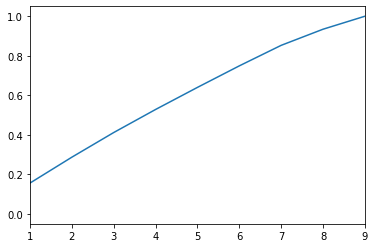

In [ ]:
#  find optimal num components to use (n) by plotting explained variance ratio (2 points)
cum_evr = np.insert(cum_evr, 0, 0, axis=0)
plt.xlim(1, 9)
plt.plot(cum_evr)


####We can see from above that the top seven features are more prominent in the model but there is no leveling off in the model so we have kept all 9.

Also, as we have done before, we won't be using the pca scaled data

###5f. Classification
So far we have used regression to directly predict flight prices and now we will use classification techniques to predict whether for a given flight, the flight prive will be above average or below average. 
This is similar to the Google Flight Tool which shows whether a given flight price is typical at the moment or not. 





In [ ]:
# Classification based on whether the prices for the flight are above average for the same source-destination pair

#avg base fare per route for non stop flights
avg_base_fare_nonstop_query = """Select startingAirport, destinationAirport, avg(baseFare) as avg_base_fare FROM flight_df WHERE isNonStop = 1 Group by startingAirport, destinationAirport order by startingAirport asc, destinationAirport asc, avg(baseFare) desc"""
avg_base_fare_nonstop_df = sqldf(avg_base_fare_nonstop_query, locals())



In [ ]:
print(avg_base_fare_nonstop_df.head(20))

   startingAirport destinationAirport  avg_base_fare
0              ATL                BOS     257.115805
1              ATL                CLT     210.662723
2              ATL                DEN     252.044376
3              ATL                DFW     194.228812
4              ATL                DTW     248.663923
5              ATL                EWR     197.420205
6              ATL                IAD     158.351715
7              ATL                JFK     178.057623
8              ATL                LAX     379.093363
9              ATL                LGA     170.098475
10             ATL                MIA     161.966177
11             ATL                ORD     209.678635
12             ATL                PHL     194.099365
13             ATL                SFO     402.956358
14             BOS                ATL     258.090930
15             BOS                CLT     191.168016
16             BOS                DEN     304.206074
17             BOS                DFW     290.

In [ ]:
#function finds average price and everything above and at that average is set to 1 or else set to 0
def get_avg(source, destination):
  #print("get_avg, source: " + source + ", destination: " + destination)
  return avg_base_fare_nonstop_df[(avg_base_fare_nonstop_df['startingAirport'] == str(source)) & (avg_base_fare_nonstop_df['destinationAirport'] == str(destination))].iloc[0]['avg_base_fare']

def get_above_average(source, destination, baseFare):
  #print("source: " + source + ", destination: " + destination + ", baseFare: " + str(baseFare))
  avgFare = get_avg(source, destination)
  if  avgFare < baseFare:
    return 1
  return 0

In [ ]:
#practice query
source = "ATL"
destination = "DFW"
print(avg_base_fare_nonstop_df[(avg_base_fare_nonstop_df['startingAirport'] == str(source)) & (avg_base_fare_nonstop_df['destinationAirport'] == str(destination))].iloc[0]["avg_base_fare"])

194.22881238155296


In [ ]:
#applying above function 
flight_nonstop_ml_classification_df = flight_nonstop_df.copy()
flight_nonstop_ml_classification_df.reset_index(inplace=True)
flight_nonstop_ml_classification_df['above_average'] = flight_nonstop_ml_classification_df.apply(lambda x: get_above_average(x.startingAirport, x.destinationAirport, x.baseFare), axis=1)

In [ ]:
# Check for class imbalance
print(len(flight_nonstop_ml_classification_df[flight_nonstop_ml_classification_df['above_average'] == 1]))
print(len(flight_nonstop_ml_classification_df[flight_nonstop_ml_classification_df['above_average'] == 0]))

88268
124446


In [ ]:
# # There are 88268 rows where flight prices are above_average and 124446 rows where flight prices are not above_average
# So we will only keep 88268 records of rows where flight prices are not above average

flight_nonstop_ml_classification_df_above_avg_1 = flight_nonstop_ml_classification_df[flight_nonstop_ml_classification_df["above_average"] == 1]
flight_nonstop_ml_classification_df_above_avg_0 = flight_nonstop_ml_classification_df[flight_nonstop_ml_classification_df["above_average"] == 0]

#only keep the number of samples as there are in above_average
flight_nonstop_ml_classification_df_above_avg_0 = flight_nonstop_ml_classification_df_above_avg_0.sample(n = len(flight_nonstop_ml_classification_df_above_avg_1))

flight_nonstop_ml_classification_df_resampled = pd.concat([flight_nonstop_ml_classification_df_above_avg_1, flight_nonstop_ml_classification_df_above_avg_0], axis = 0)

#flight_nonstop_ml_classification_df_resampled = flight_nonstop_ml_classification_df.copy()
# shuffle the data frame
flight_nonstop_ml_classification_df_resampled = flight_nonstop_ml_classification_df_resampled.sample(frac = 1)

flight_nonstop_ml_classification_df_resampled.reset_index(drop=True)

,index,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,...,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode,flightDayOfWeek,searchDayOfWeek,above_average
0,112599,1e0519b33be978dd9af42111e6af7553,2022-05-09,2022-06-29,LGA,MIA,G7AJZNN3,PT3H8M,0,False,...,LGA,American Airlines,AA,Boeing 737-800,11280,1104,coach,Wednesday,Monday,1
1,748959,b15ca09cde41e83bcda3e299780f31d1,2022-09-21,2022-09-29,PHL,BOS,S3AJZNB3,PT1H32M,0,True,...,PHL,American Airlines,AA,Airbus A320,5520,280,coach,Thursday,Wednesday,0
2,691067,d382fd7f9f3c91ee4fadd009e3502df4,2022-09-08,2022-10-13,ORD,DEN,WAA7AWEN,PT2H45M,0,False,...,ORD,United,UA,Boeing 777,9900,903,coach,Thursday,Thursday,0
3,545197,335511a66992c0e23e7879da2cbb1a4d,2022-08-09,2022-08-21,DEN,BOS,MA3OA0MQ,PT4H5M,0,False,...,DEN,Delta,DL,NaN,14700,1763,coach,Sunday,Tuesday,1
4,340396,cba06410d95315e904e165142effb935,2022-07-03,2022-08-13,IAD,LGA,SAA2AFBN,PT1H40M,0,True,...,IAD,United,UA,NaN,6000,221,coach,Saturday,Sunday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176531,164445,9d9c1e4b8b5aad1ccafc2c9f488e195e,2022-05-26,2022-07-12,DTW,IAD,VAVSA0BC,PT1H31M,0,True,...,DTW,Delta,DL,Canadair Regional Jet 900,5460,391,coach,Tuesday,Thursday,0
176532,16997,645ae27daa7e34f930a61ac99f5e4c69,2022-04-20,2022-05-02,ATL,JFK,TA7QA0ML,PT2H17M,0,False,...,ATL,Delta,DL,Boeing 737-900,8220,762,coach,Monday,Wednesday,0
176533,194968,9c4d80749df7828d2e455b21a3d89057,2022-06-03,2022-06-06,JFK,BOS,NI3QUEY5,PT1H16M,0,False,...,JFK,American Airlines,AA,Embraer 190,4560,185,coach,Monday,Friday,0
176534,645996,755bb1a6b4606d3ae783ef9e0abe7a3c,2022-08-30,2022-09-15,DEN,ATL,XAUNJ0BG,PT2H50M,0,True,...,DEN,Delta,DL,Airbus A321,10200,1207,coach,Thursday,Tuesday,0


In [ ]:
#Select the feature columns and Do the label encoding
mlFeatureColumnsStopNonStopClass = mlFeatureColumnsStopNonStop.copy()
mlFeatureColumnsStopNonStopClass.append('above_average')
flight_nonstop_ml_classification_df_resampled = flight_nonstop_ml_classification_df_resampled[mlFeatureColumnsStopNonStopClass]
flight_nonstop_encoded_df = perform_label_encoding(flight_nonstop_ml_classification_df_resampled)
flight_nonstop_encoded_df.head()

,startingAirport,destinationAirport,isBasicEconomy,segmentsAirlineName,segmentsCabinCode,flightDayOfWeek,searchDayOfWeek,baseFare,seatsRemaining,totalTravelDistance,above_average
32059,10,11,0,1,1,6,1,163.72,7,1104.0,1
195647,14,1,1,1,1,4,6,93.02,7,280.0,0
182198,13,3,0,5,1,4,4,175.81,9,903.0,0
148458,3,1,0,2,1,3,5,459.53,2,1763.0,1
96294,7,10,1,5,1,2,3,106.05,9,221.0,0


In [ ]:
# Create X and Y
X = flight_nonstop_encoded_df.copy()
y = X['above_average']
X.drop('baseFare', axis=1, inplace=True)
X.drop('above_average', axis=1, inplace=True)
X.head()

,startingAirport,destinationAirport,isBasicEconomy,segmentsAirlineName,segmentsCabinCode,flightDayOfWeek,searchDayOfWeek,seatsRemaining,totalTravelDistance
32059,10,11,0,1,1,6,1,7,1104.0
195647,14,1,1,1,1,4,6,7,280.0
182198,13,3,0,5,1,4,4,9,903.0
148458,3,1,0,2,1,3,5,2,1763.0
96294,7,10,1,5,1,2,3,9,221.0


In [ ]:
# Split into training and test dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
#Run classification model on this dataset
# random forest classifier
#Decision Tree Classifier Depth tests
#depths = [1, 2, 5, 8, 10, 12, 15, 18, 20, 21, 22, 23, 24, 25, 30, 35, 40, 45, 50]
depths = [1, 5, 10, 15, 20, 25, 30]
estimators = [1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80]

model_accuracies = []
test_accuracies = []
clfs = []

for estimator in estimators:
  model_acc = []
  test_acc = []
  for n in depths:
    result = run_random_forest_classifier(X_train, X_test, y_train, y_test, estimator, n)
    test_acc.append(result[0])
    model_acc.append(result[1])
  model_accuracies.append(model_acc)
  test_accuracies.append(test_acc)

print(model_accuracies)
print(test_accuracies)



Random Forest Classifier. estimators: 1, depth: 1

TEST ACCURACY OF THE MODEL:  0.621190665005098
TRAINING ACCURACY OF THE MODEL:  0.6264196901464298

Random Forest Classifier. estimators: 1, depth: 5

TEST ACCURACY OF THE MODEL:  0.6570465616857369
TRAINING ACCURACY OF THE MODEL:  0.6574616931486674

Random Forest Classifier. estimators: 1, depth: 10

TEST ACCURACY OF THE MODEL:  0.674606321513538
TRAINING ACCURACY OF THE MODEL:  0.6805449344322656

Random Forest Classifier. estimators: 1, depth: 15

TEST ACCURACY OF THE MODEL:  0.6751444431856803
TRAINING ACCURACY OF THE MODEL:  0.711863086640043

Random Forest Classifier. estimators: 1, depth: 20

TEST ACCURACY OF THE MODEL:  0.6601336807522374
TRAINING ACCURACY OF THE MODEL:  0.7466578865380803

Random Forest Classifier. estimators: 1, depth: 25

TEST ACCURACY OF THE MODEL:  0.6529681658547638
TRAINING ACCURACY OF THE MODEL:  0.7711997620868383

Random Forest Classifier. estimators: 1, depth: 30

TEST ACCURACY OF THE MODEL:  0.647

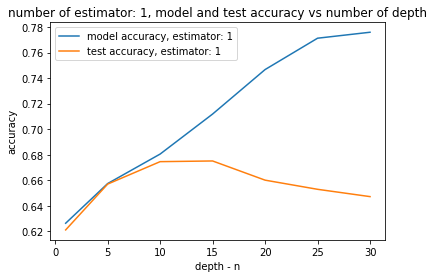

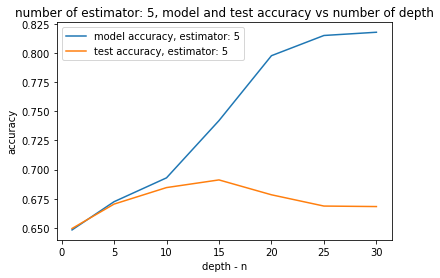

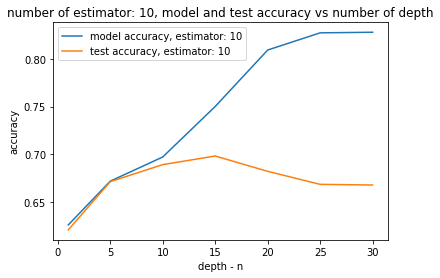

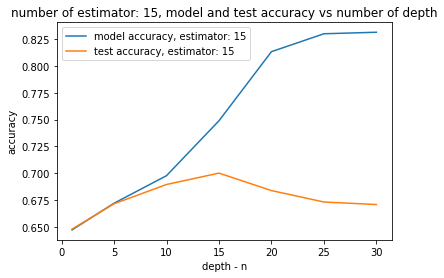

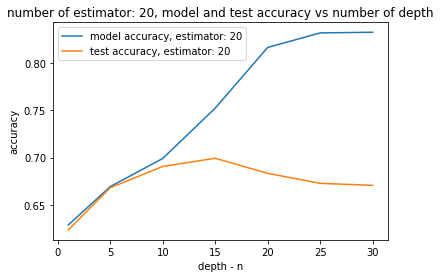

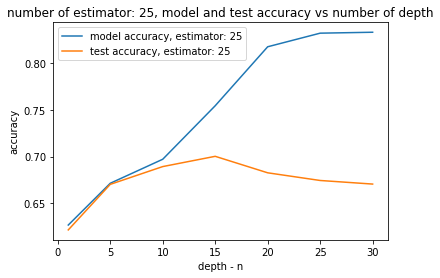

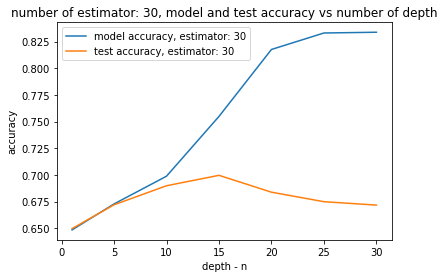

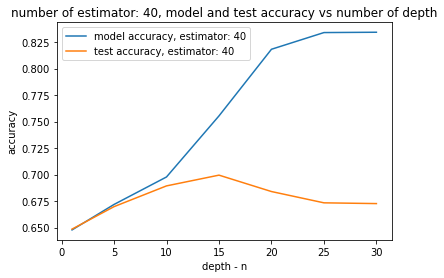

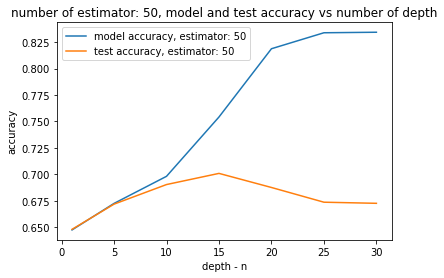

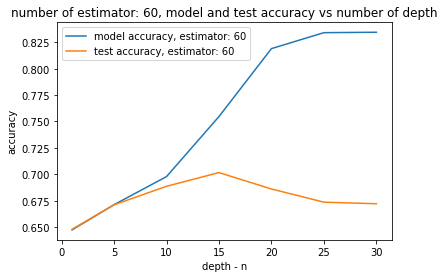

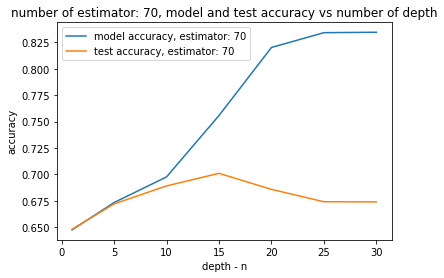

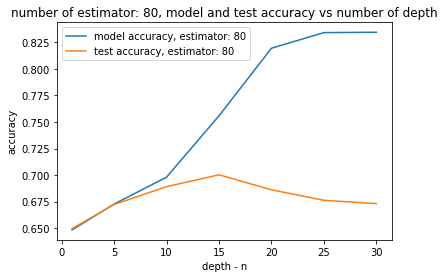

In [ ]:
#Random Forest Classifier Graph

for i in range(len(estimators)):
  plt.plot(depths, model_accuracies[i], label = "model accuracy, estimator: " + str(estimators[i]))
  plt.plot(depths, test_accuracies[i], label = "test accuracy, estimator: " + str(estimators[i]))
  plt.xlabel('depth - n')
  plt.ylabel('accuracy')
  plt.title("number of estimator: " + str(estimators[i]) + ", model and test accuracy vs number of depth")
  plt.legend()
  plt.show()


We see very similar graphs for random forest classifier on nonstop flight data as we saw with all flights data. No new findings here.

In [ ]:
# Find the point with max accuracy

max_so_far = 0
estimator = 0
depth = 0
i = 0
for test_acc in test_accuracies:
  max_acc = max(test_acc)
  if max_acc > max_so_far:
    max_so_far = max(max_so_far, max_acc)
    estimator = estimators[i]
    depth = depths[test_acc.index(max_acc)]
  i = i + 1

print("Random Forest Classifier Max accuracy of: " + str(max_so_far) + ", at n_estimator: " + str(estimator) + ", depth: " + str(depth))



Random Forest Classifier Max accuracy of: 0.7016256938937351, at n_estimator: 60, depth: 15


In [ ]:
# Run random forest classifier for the best score parameters and plot graph
print("\n The best random forest classifier results: ")
result = run_random_forest_classifier(X_train, X_test, y_train, y_test, 60, 15)


 The best random forest classifier results: 

Random Forest Classifier. estimators: 60, depth: 15

TEST ACCURACY OF THE MODEL:  0.7013424719610286
TRAINING ACCURACY OF THE MODEL:  0.7548007477270796


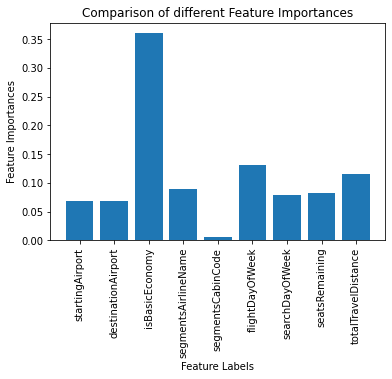

In [ ]:
# Feature importance

# Plotting a Bar Graph to compare the models
# Shows importance of label features - most important is Total Travel Distance
plt.bar(X.columns, result[2].feature_importances_)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.xticks( rotation='vertical')
plt.show()

Similar to random forest classification on all flights data, we see that isBasicEconomy is the most important feature with nonstop flight dataset.
One new thing to observe is that flightDayOfWeek is second most important feature for nonstop flights.

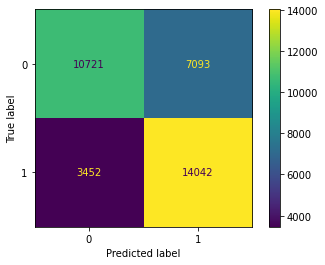

In [ ]:
# confusion matrix for visulaization
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split


confmat = confusion_matrix(y_true=y_test, y_pred=result[2].predict(X_test))
confmat
disp = ConfusionMatrixDisplay(confusion_matrix=confmat,display_labels=result[2].classes_)
disp.plot()
plt.show()

The covariance matrix above gives a good idea about how good of a job model is doing with True Positives, True Negatives, False Positives and False Negatives.
We see that the classification model above is doing a good job at prediction.
In real world, able to predict with > 70% accuracy is good.

###6. Test Multiple Stop data

Text(0.5, 1.0, 'Multiple_Stop_Flight_Prices Correlation')

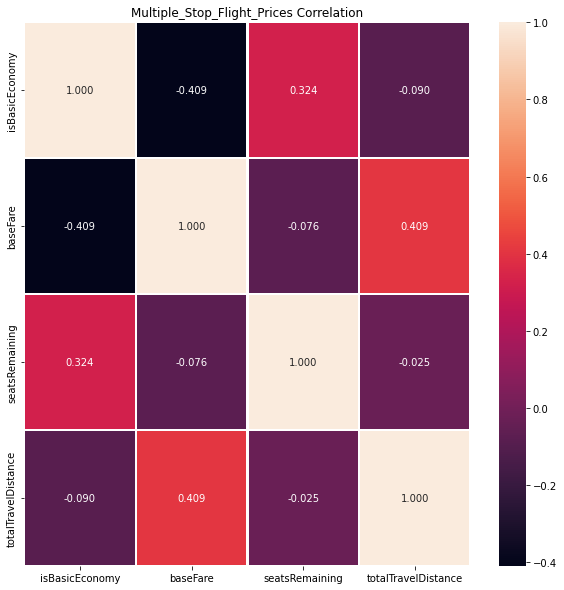

In [ ]:
#Try out different encoding methods- 12/15/20222
#mlFeatureColumns = ['startingAirport', 'destinationAirport', 'isBasicEconomy', 'baseFare', 'seatsRemaining', 'totalTravelDistance', 'segmentsAirlineName', 'flightDayOfWeek', 'searchDayOfWeek']
flight_stop_ml_df = flight_stop_df[mlFeatureColumnsStopNonStop]
fig, ax = plt.subplots(figsize=(10,10)) 

sns.heatmap(flight_stop_ml_df.corr(), annot=True, linewidths= 1.5, ax = ax, fmt='.3f')
ax.set_title('Multiple_Stop_Flight_Prices Correlation')

We see similar correlateion matrix as we saw with all flights and nonstop flights. Nothing new to call out

In [ ]:
# Perform label encoding

X = perform_label_encoding(flight_stop_ml_df)

X.reset_index(drop=True)
y = X['baseFare']

X.head()


,startingAirport,destinationAirport,isBasicEconomy,segmentsAirlineName,segmentsCabinCode,flightDayOfWeek,searchDayOfWeek,baseFare,seatsRemaining,totalTravelDistance
1,0,5,0,50,1,3,2,669.76,9,1331.0
2,0,9,0,14,1,3,2,322.79,7,1940.0
3,0,10,0,93,1,3,2,329.30,1,762.0
5,1,3,0,50,1,3,2,278.14,9,2480.0
6,1,7,0,50,1,3,2,495.81,3,406.0


Text(0.5, 1.0, 'Multiple_Stop_Flight_Prices Correlation')

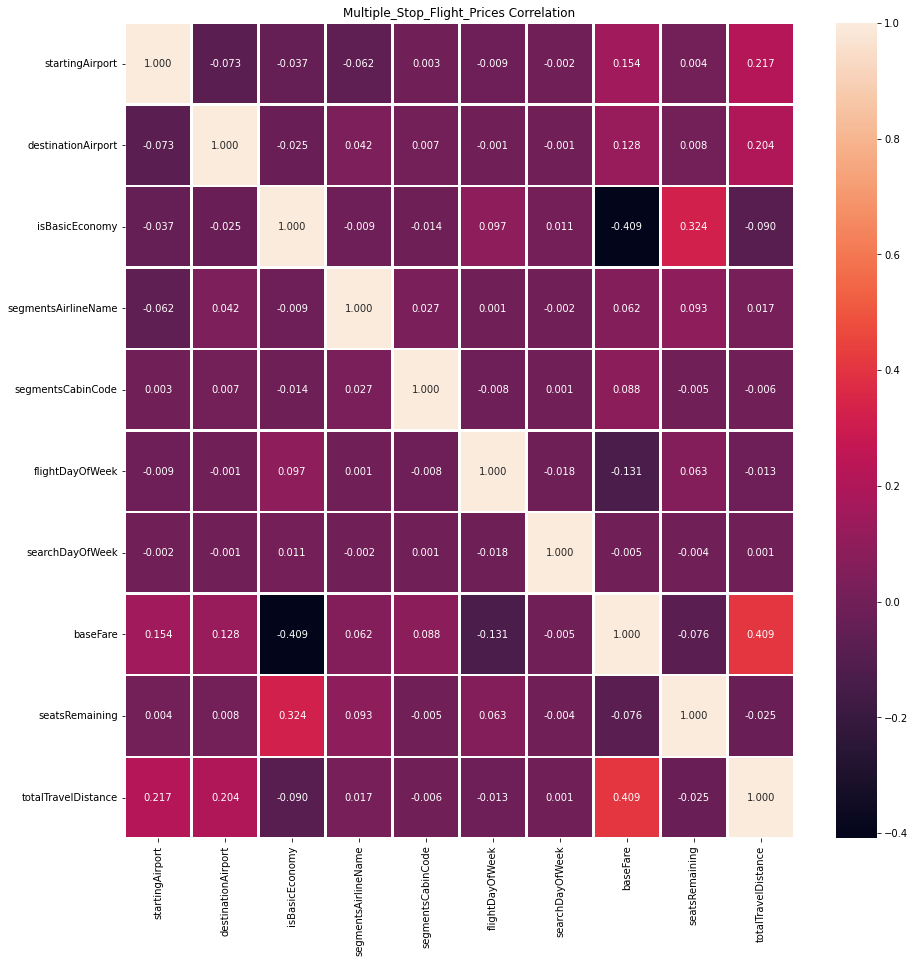

In [ ]:
fig, ax = plt.subplots(figsize=(15,15)) 

sns.heatmap(X.corr(), annot=True, linewidths= 1.5, ax = ax, fmt='.3f')
ax.set_title('Multiple_Stop_Flight_Prices Correlation')

Again, we see very similar observation with correlation matrix as we saw with all flights and nonstop flights

In [ ]:
X.drop('baseFare', axis=1, inplace=True)

In [ ]:
#split test train 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

####Linear Regression: Multiple Stop Data


Runnning linear regression
Score: 1.0
Mean Absolute Error (MAE):  105.6143094346604
Mean Squared Error (MSE):  21726.39113243599
Root Mean Squared Error (RMSE):  147.39874874786418


(0.0, 1500.0)

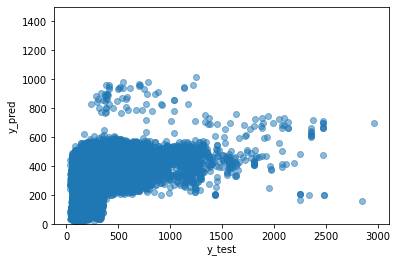

In [ ]:
#Linear regression

from sklearn.linear_model import LinearRegression

result = run_linear_regression(X_train, X_test, y_train, y_test)

plt.scatter(y_test, result[1], alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.ylim(0,1500)

The linear regression graph above shows that model is not doing a good job at prediction.

#####Classification- multi-stop

In [ ]:
# Classification based on whether the prices for the flight are above average for the same source-destination pair

#avg base fare per route for multiple stop flights
avg_base_fare_stop_query = """Select startingAirport, destinationAirport, avg(baseFare) as avg_base_fare FROM flight_df WHERE isNonStop = 0 Group by startingAirport, destinationAirport order by startingAirport asc, destinationAirport asc, avg(baseFare) desc"""
avg_base_fare_stop_df = sqldf(avg_base_fare_stop_query, locals())

In [ ]:
print(avg_base_fare_stop_df.head(20))

   startingAirport destinationAirport  avg_base_fare
0              ATL                BOS     237.574800
1              ATL                CLT     313.956002
2              ATL                DEN     294.383275
3              ATL                DFW     236.597282
4              ATL                DTW     283.035732
5              ATL                EWR     186.541715
6              ATL                IAD     240.191707
7              ATL                JFK     309.344246
8              ATL                LAX     342.613695
9              ATL                LGA     164.698509
10             ATL                MIA     287.330201
11             ATL                OAK     524.493771
12             ATL                ORD     207.620576
13             ATL                PHL     253.731160
14             ATL                SFO     402.242794
15             BOS                ATL     239.555395
16             BOS                CLT     194.126263
17             BOS                DEN     293.

In [ ]:
#function finds average price and everything above and at that average is set to 1 or else set to 0
def get_avg(source, destination):
  #print("get_avg, source: " + source + ", destination: " + destination)
  return avg_base_fare_stop_df[(avg_base_fare_stop_df['startingAirport'] == str(source)) & (avg_base_fare_stop_df['destinationAirport'] == str(destination))].iloc[0]['avg_base_fare']

def get_above_average(source, destination, baseFare):
  #print("source: " + source + ", destination: " + destination + ", baseFare: " + str(baseFare))
  avgFare = get_avg(source, destination)
  if  avgFare < baseFare:
    return 1
  return 0

In [ ]:
#applying above function 
flight_stop_ml_classification_df = flight_stop_ml_df.copy()
flight_stop_ml_classification_df['above_average'] = flight_stop_ml_classification_df.apply(lambda x: get_above_average(x.startingAirport, x.destinationAirport, x.baseFare), axis=1)

In [ ]:
# Check for class imbalance
print(len(flight_stop_ml_classification_df[flight_stop_ml_classification_df['above_average'] == 1]))
print(len(flight_stop_ml_classification_df[flight_stop_ml_classification_df['above_average'] == 0]))

249728
298138


In [ ]:
#Do the label encoding
from sklearn.preprocessing import LabelEncoder

train_categorical_data = flight_stop_ml_classification_df.select_dtypes(exclude=['int64', 'float','int32'])
train_numerical_data = flight_stop_ml_classification_df.select_dtypes(include=['int64', 'float','int32'])
train_categorical_data.head()

le = LabelEncoder()
train_categorical_data = train_categorical_data.apply(LabelEncoder().fit_transform)
train_categorical_data.head()

X = pd.concat([train_categorical_data, train_numerical_data], axis=1)

X.reset_index(drop=True)
y = X['above_average']

X.head()

,startingAirport,destinationAirport,isBasicEconomy,segmentsAirlineName,segmentsCabinCode,flightDayOfWeek,searchDayOfWeek,baseFare,seatsRemaining,totalTravelDistance,above_average
1,0,5,0,50,1,3,2,669.76,9,1331.0,1
2,0,9,0,14,1,3,2,322.79,7,1940.0,0
3,0,10,0,93,1,3,2,329.30,1,762.0,1
5,1,3,0,50,1,3,2,278.14,9,2480.0,0
6,1,7,0,50,1,3,2,495.81,3,406.0,1


In [ ]:
# remove baseFare and above_average from X
X.drop('baseFare', axis=1, inplace=True)
X.drop('above_average', axis=1, inplace=True)

In [ ]:
# Split into training and test dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
#Run classification model on this dataset
# random forest classifier

result = run_random_forest_classifier(X_train, X_test, y_train, y_test, 60, 15)


Random Forest Classifier. estimators: 60, depth: 15

TEST ACCURACY OF THE MODEL:  0.754001861755526
TRAINING ACCURACY OF THE MODEL:  0.7820767889899884


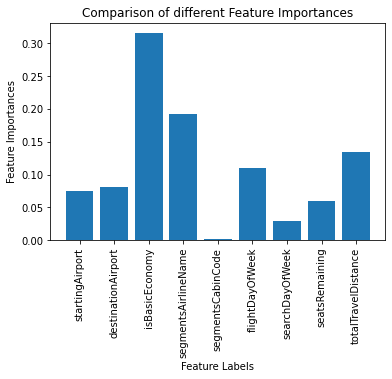

In [ ]:
# Feature importance

# Plotting a Bar Graph to compare the models
# Shows importance of label features - most important is Total Travel Distance
plt.bar(X.columns, result[2].feature_importances_)
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.xticks( rotation='vertical')
plt.show()

We see that isBasicEconomy and segmentAirlineName are the two most important feature for classfication using random forest classifier

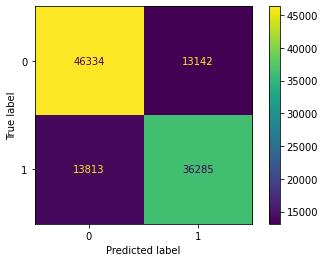

In [ ]:
# confusion matrix for visulaization
confmat = confusion_matrix(y_true=y_test, y_pred=result[2].predict(X_test))
confmat
disp = ConfusionMatrixDisplay(confusion_matrix=confmat,display_labels=result[2].classes_)
disp.plot()
plt.show()

We see that random forest classifier is more better on the multi stop flight data as compared to non stop flight data. The accuracy is ~75% with multi stop flights as compared to ~70% with nonstop flights

#7. Conclusion 

* Flight prediction is definitely a hard problem
* For regression analysis, random forest regression yields the best result overall
* For classfication problems, we see that random forest classifier gives the best result.
* Hyper parameter tuning is very important in order to avoid overfitting and get the best accuracy

###7a. Summary of what was done:

* Data import and sampling
* Cleaning the data
* Deriving columns based on the data
* Writing panda SQL queries to fetch the aggregate records
* Visualization of the data with help of graphs
* Correlation matrix generation to help with further analysis
* Ran PCA to reduce the dimension and compared the performance of PCA data with non pca scaled data
* Spark dataframe
* Linear Regression on the full dataset
* Random Forest Classification
* Decision Tree Classifier
* Confusion Matrix
* Partition the data into non stop flights and stop flights and run the same analysis as above


#### High level results as below:
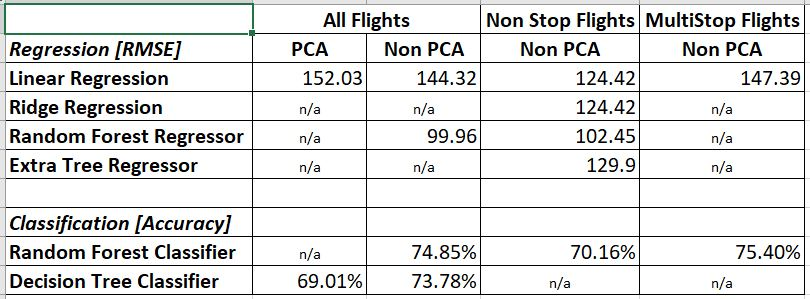




####Spark data frame results:

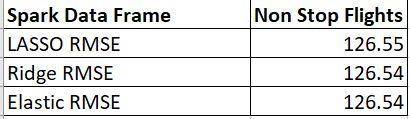

#8. Challenges

* Dealing with large amount of data:
 * There are ~80 million rows in the original dataset, which makes it difficult to load. The colab kept crashing,and running out of memory even after upgrading to highest instance with 85Gb.
 * Tried various sampling approach and observed that that aggregate level analysis was the same.
 * Hence, resorted to use the 1% sample of the data which is about 800k rows
* While building classification models, observed overfitting where training accuracy was much higher than the test accuracy
 * Did the hyperparameter tuning by running the various classification models with different configuration to figure out the optimal configuration
* Feature selection:
  * Given there are lot of columns, it required mix of correlation analysis, manual analysis, using hypothesis and trying out separate set of feature columns to arrive with best optimal set of features to use
* Formulation of the problem:
 * Given flight data is very generic information and something very easy to understand, there are a lot of natural biases while looking at the data. But when actually doing machine learning, got to learn that not all the biases hold true when we actually apply the machine learning
 * e.g. Some of the accuracy measures on the entire data set are better than on separate dataset for nonstop and multistop flights. This appears to be opposite of the natual intuition



##9. Future Enhancements

* Would like to try out building route and airline specific models to see whether that will help with better prediction
* Try to do single flight level modeling and predict how the prices for a particular flight changes over time.